The goal of the home price regression competition is to predict the sale price of the home based on information about the home. The competition is described at https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques

The data is described in data_predictions.txt.

Import the necessary packages. Before submitting to the competition, click the triple dots next to the submit button. Copy and paste the following command into the window without the number symbol.

In [1]:
#!pip install feature-engine

In [2]:
# Core
import numpy as np
import pandas as pd
import os
import random
import warnings

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.model_selection import KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.feature_selection import mutual_info_regression
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
from feature_engine.encoding import RareLabelEncoder

# Tree-based model
import xgboost as xgb
import optuna

Set the random seed to 42 to ensure repeatability.

In [3]:
RANDOM_STATE = 42
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
seed_everything(seed=RANDOM_STATE)

Set the location of the data files based on running on a local machine or kaggle website.

In [4]:
KAGGLE = False
warnings.filterwarnings("ignore")

In [5]:
if KAGGLE:
    train_csv = '/kaggle/input/house-prices-advanced-regression-techniques/train.csv'
    test_csv = '/kaggle/input/house-prices-advanced-regression-techniques/test.csv'
else:
    train_csv = './data/train.csv'
    test_csv = './data/test.csv'
    

train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

In [6]:
print(train_df.shape)
print(test_df.shape)

(1460, 81)
(1459, 80)


The dataset is small with only 1460 rows for train.

Create a list of columns that are numeric or categorical.

In [7]:
cat_cols = train_df.drop(columns=['SalePrice', 'Id']).select_dtypes(include=["object"]).columns.tolist()
num_cols = train_df.drop(columns=['SalePrice', 'Id']).select_dtypes(exclude=["object"]).columns.tolist()

len(cat_cols), len(num_cols)

(43, 36)

MSSubClass is a categorical column that is misidentified as a numerical column. Month sold and year sold should also be categorical because of seasonality.

In [8]:
cat_cols.append('MSSubClass')
num_cols.remove('MSSubClass')

cat_cols.append('MoSold')
num_cols.remove('MoSold')

cat_cols.append('YrSold')
num_cols.remove('YrSold')

Remove the Id column from the train dataset.

In [9]:
train_df.drop(columns=['Id'], inplace=True)

Check for duplicated rows in the train and test dataset.

In [10]:
print("Duplicated Rows in Train:",train_df.duplicated().sum())
print("Duplicated Rows in Test:",test_df.duplicated().sum())

Duplicated Rows in Train: 0
Duplicated Rows in Test: 0


There are no duplicated rows in the train and test set.

Check for missing values in the data.

In [11]:
def missing_data_table(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = total / len(df)
    missing_data = pd.concat([total, percent], axis=1, keys=["Total", "Percent"])
    # Filter columns that actually have missing values.
    return missing_data[missing_data["Total"] > 0]

print("Missing data in train_df:")
print(missing_data_table(train_df))
print("Missing data in test_df:")
print(missing_data_table(test_df))

Missing data in train_df:
              Total   Percent
PoolQC         1453  0.995205
MiscFeature    1406  0.963014
Alley          1369  0.937671
Fence          1179  0.807534
MasVnrType      872  0.597260
FireplaceQu     690  0.472603
LotFrontage     259  0.177397
GarageYrBlt      81  0.055479
GarageCond       81  0.055479
GarageType       81  0.055479
GarageFinish     81  0.055479
GarageQual       81  0.055479
BsmtExposure     38  0.026027
BsmtFinType2     38  0.026027
BsmtCond         37  0.025342
BsmtQual         37  0.025342
BsmtFinType1     37  0.025342
MasVnrArea        8  0.005479
Electrical        1  0.000685
Missing data in test_df:
              Total   Percent
PoolQC         1456  0.997944
MiscFeature    1408  0.965045
Alley          1352  0.926662
Fence          1169  0.801234
MasVnrType      894  0.612748
FireplaceQu     730  0.500343
LotFrontage     227  0.155586
GarageYrBlt      78  0.053461
GarageQual       78  0.053461
GarageFinish     78  0.053461
GarageCond       78

There are some columns that have a lot of NaNs. However, for some columns, NaNs are expected. For example, pool quality is Na if no pool exists. For those rows, Nas should not be imputed.

In [12]:
print(train_df.dtypes)
discrete_features = [pd.api.types.is_integer_dtype(t) for t in train_df.dtypes]
print(train_df.columns[discrete_features].tolist())

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 80, dtype: object
['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']


In [13]:
rows_na_expected = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']

Create some functions to describe the data.

In [14]:
def find_outliers_iqr(df, column_name):
    q1 = df[column_name].quantile(0.25)
    q3 = df[column_name].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outliers = df[(df[column_name] < lower_bound) | (df[column_name] > upper_bound)]
    return outliers

In [15]:
def describe_col(col_name):
    train_describe = train_df[col_name].describe()
    train_describe['per missing'] = train_df[col_name].isnull().sum()/len(train_df)
    train_describe['numb outliers'] = find_outliers_iqr(train_df, col_name).shape[0]
    train_describe.name = 'train_df'
    test_describe = test_df[col_name].describe()
    test_describe['per missing'] = test_df[col_name].isnull().sum()/len(test_df)
    test_describe['numb outliers iqr'] = find_outliers_iqr(test_df, col_name).shape[0]
    test_describe.name = 'test_df'
    return pd.concat([train_describe, test_describe], axis=1)
print(num_cols[0])
print(describe_col(num_cols[0]))

LotFrontage
                      train_df      test_df
count              1201.000000  1232.000000
mean                 70.049958    68.580357
std                  24.284752    22.376841
min                  21.000000    21.000000
25%                  59.000000    58.000000
50%                  69.000000    67.000000
75%                  80.000000    80.000000
max                 313.000000   200.000000
per missing           0.177397     0.155586
numb outliers        88.000000          NaN
numb outliers iqr          NaN   100.000000


In [16]:
def plot_overlaid_histograms(df1, df2, col_name, df1_label, df2_label, bins):
    # Plot overlaid histograms
    plt.hist(df1[col_name], bins=bins, alpha=0.7, label=df1_label, color='blue')
    plt.hist(df2[col_name], bins=bins, alpha=0.7, label=df2_label, color='orange')

    plt.title('Overlaid Histograms')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

def plot_multi_hist(df1, df2, col_name, df1_label, df2_label, bins):
    fig, axs = plt.subplots(1, 2, figsize=(15,6)) # 1 row, 2 columns
    axs[0].hist(df1[col_name], bins=bins, color='blue')
    axs[0].set_title(df1_label)
    axs[1].hist(df2[col_name], bins=bins, label=df2_label, color='orange')
    axs[1].set_title(df2_label)
    plt.show()

def plot_multi_hist2(df1, df2, col_name, df1_label, df2_label, bins):
    fig, axs = plt.subplots(1, 2, figsize=(15,6)) # 1 row, 2 columns
    df1[col_name].value_counts().sort_index(ascending=False).plot.hist(bins=bins, color='blue', ax=axs[0], title=df1_label)
    df2[col_name].value_counts().sort_index(ascending=False).plot.hist(bins=bins, color='orange', ax=axs[1], title=df2_label)
    plt.show()

def plot_multi_bar(df1, df2, col_name, df1_label, df2_label):
    fig, axs = plt.subplots(1, 2, figsize=(15,6)) # 1 row, 2 columns
    df1[col_name].value_counts().plot.bar(color='blue', ax=axs[0], title=df1_label)
    df2[col_name].value_counts().plot.bar(color='orange', ax=axs[1], title=df2_label)
    plt.show()

LotFrontage
                      train_df      test_df
count              1201.000000  1232.000000
mean                 70.049958    68.580357
std                  24.284752    22.376841
min                  21.000000    21.000000
25%                  59.000000    58.000000
50%                  69.000000    67.000000
75%                  80.000000    80.000000
max                 313.000000   200.000000
per missing           0.177397     0.155586
numb outliers        88.000000          NaN
numb outliers iqr          NaN   100.000000


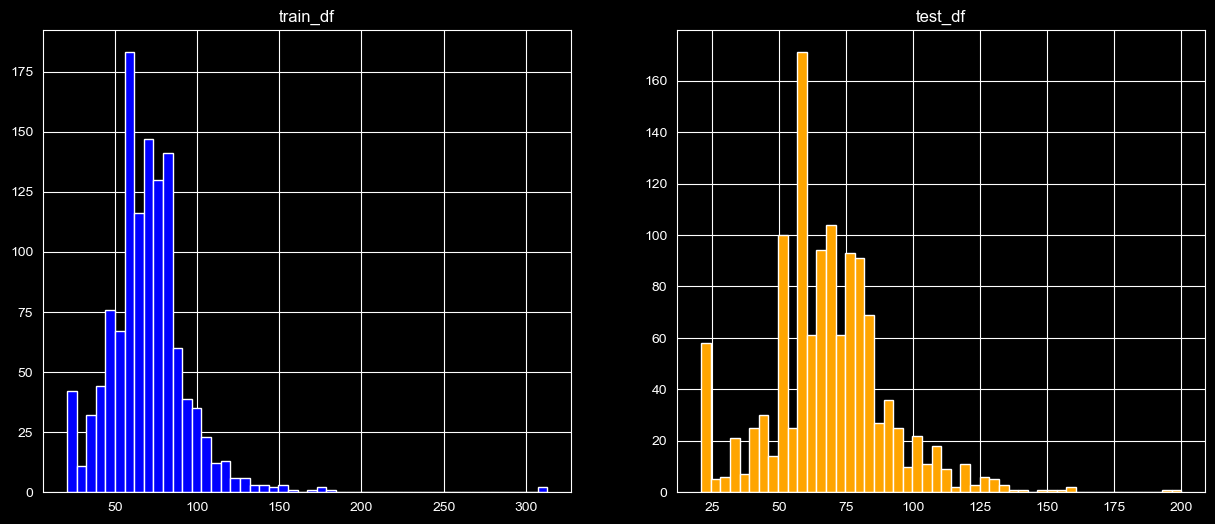

LotArea
                        train_df       test_df
count                1460.000000   1459.000000
mean                10516.828082   9819.161069
std                  9981.264932   4955.517327
min                  1300.000000   1470.000000
25%                  7553.500000   7391.000000
50%                  9478.500000   9399.000000
75%                 11601.500000  11517.500000
max                215245.000000  56600.000000
per missing             0.000000      0.000000
numb outliers          69.000000           NaN
numb outliers iqr            NaN     60.000000


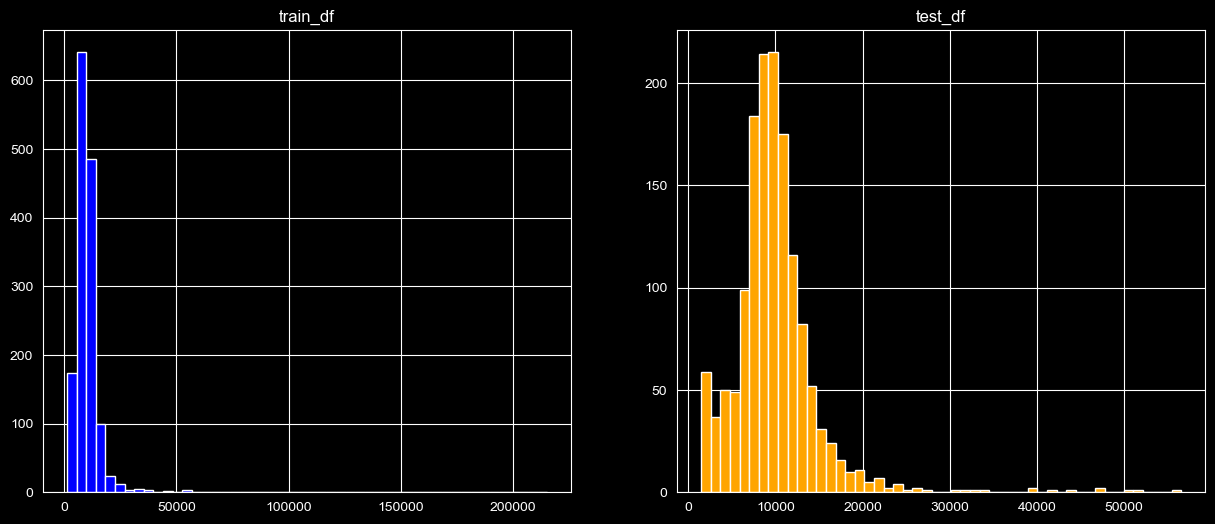

OverallQual
                      train_df      test_df
count              1460.000000  1459.000000
mean                  6.099315     6.078821
std                   1.382997     1.436812
min                   1.000000     1.000000
25%                   5.000000     5.000000
50%                   6.000000     6.000000
75%                   7.000000     7.000000
max                  10.000000    10.000000
per missing           0.000000     0.000000
numb outliers         2.000000          NaN
numb outliers iqr          NaN     2.000000


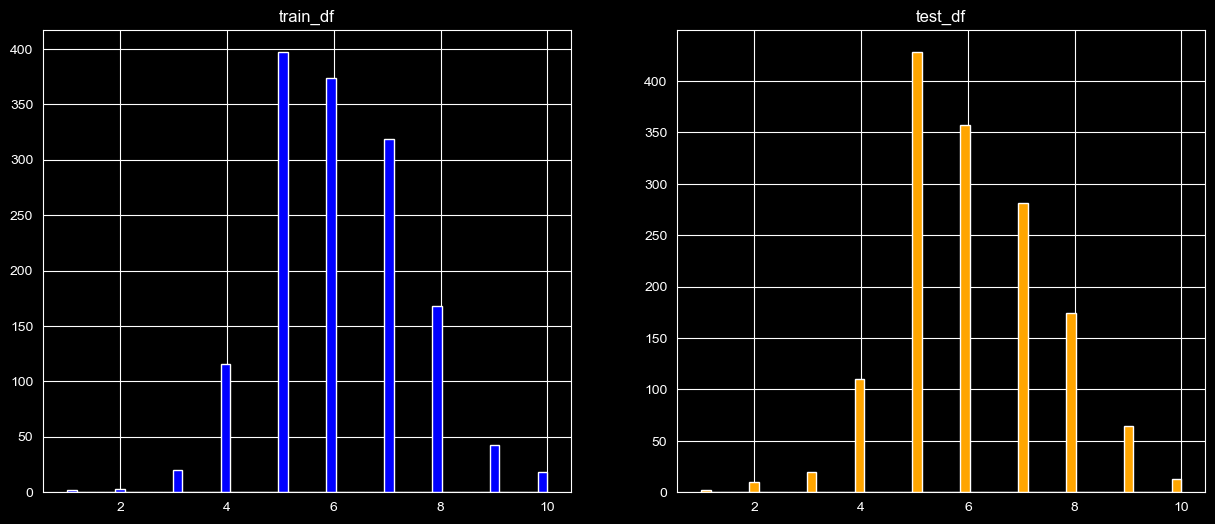

OverallCond
                      train_df      test_df
count              1460.000000  1459.000000
mean                  5.575342     5.553804
std                   1.112799     1.113740
min                   1.000000     1.000000
25%                   5.000000     5.000000
50%                   5.000000     5.000000
75%                   6.000000     6.000000
max                   9.000000     9.000000
per missing           0.000000     0.000000
numb outliers       125.000000          NaN
numb outliers iqr          NaN   127.000000


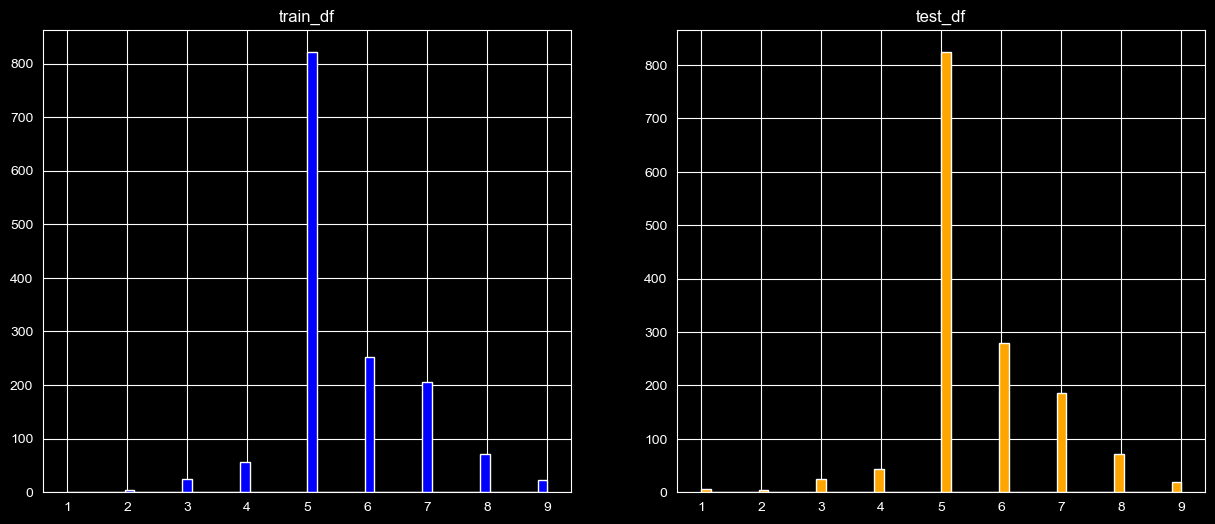

YearBuilt
                      train_df      test_df
count              1460.000000  1459.000000
mean               1971.267808  1971.357779
std                  30.202904    30.390071
min                1872.000000  1879.000000
25%                1954.000000  1953.000000
50%                1973.000000  1973.000000
75%                2000.000000  2001.000000
max                2010.000000  2010.000000
per missing           0.000000     0.000000
numb outliers         7.000000          NaN
numb outliers iqr          NaN     2.000000


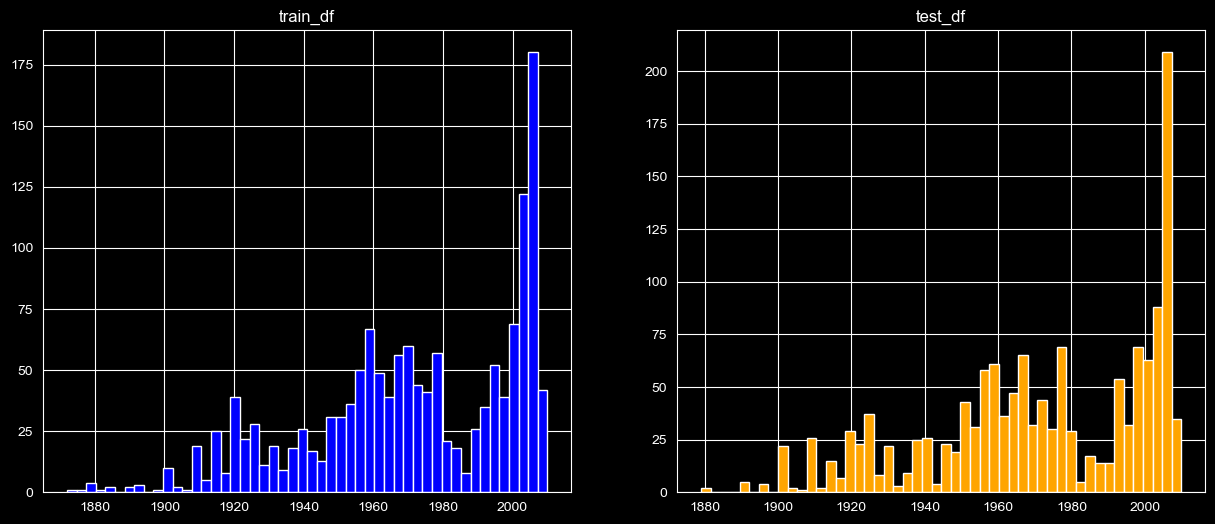

YearRemodAdd
                      train_df      test_df
count              1460.000000  1459.000000
mean               1984.865753  1983.662783
std                  20.645407    21.130467
min                1950.000000  1950.000000
25%                1967.000000  1963.000000
50%                1994.000000  1992.000000
75%                2004.000000  2004.000000
max                2010.000000  2010.000000
per missing           0.000000     0.000000
numb outliers         0.000000          NaN
numb outliers iqr          NaN     0.000000


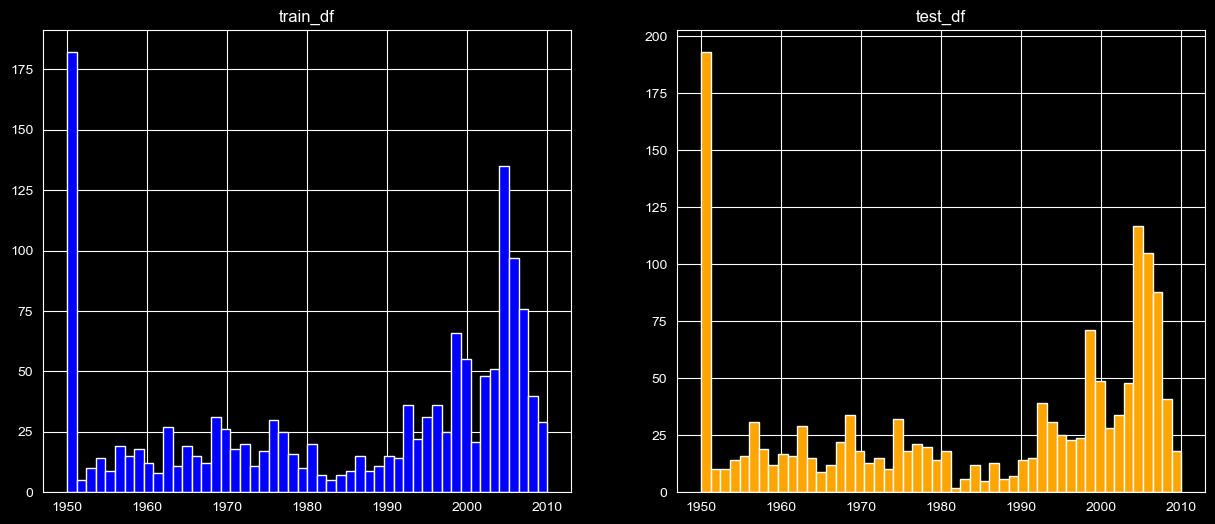

MasVnrArea
                      train_df      test_df
count              1452.000000  1444.000000
mean                103.685262   100.709141
std                 181.066207   177.625900
min                   0.000000     0.000000
25%                   0.000000     0.000000
50%                   0.000000     0.000000
75%                 166.000000   164.000000
max                1600.000000  1290.000000
per missing           0.005479     0.010281
numb outliers        96.000000          NaN
numb outliers iqr          NaN   102.000000


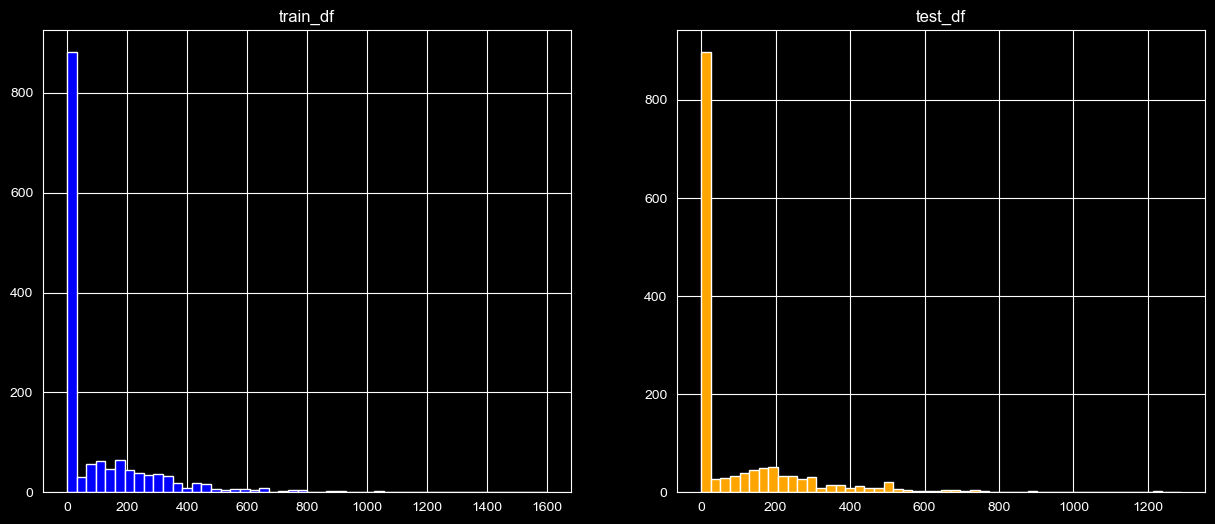

BsmtFinSF1
                      train_df      test_df
count              1460.000000  1458.000000
mean                443.639726   439.203704
std                 456.098091   455.268042
min                   0.000000     0.000000
25%                   0.000000     0.000000
50%                 383.500000   350.500000
75%                 712.250000   753.500000
max                5644.000000  4010.000000
per missing           0.000000     0.000685
numb outliers         7.000000          NaN
numb outliers iqr          NaN     8.000000


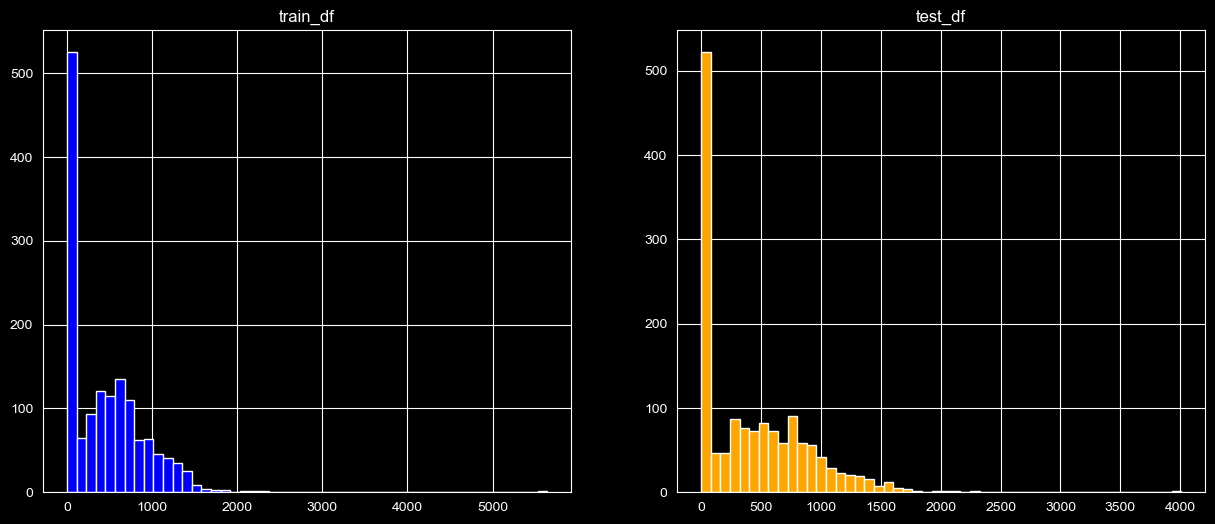

BsmtFinSF2
                      train_df      test_df
count              1460.000000  1458.000000
mean                 46.549315    52.619342
std                 161.319273   176.753926
min                   0.000000     0.000000
25%                   0.000000     0.000000
50%                   0.000000     0.000000
75%                   0.000000     0.000000
max                1474.000000  1526.000000
per missing           0.000000     0.000685
numb outliers       167.000000          NaN
numb outliers iqr          NaN   180.000000


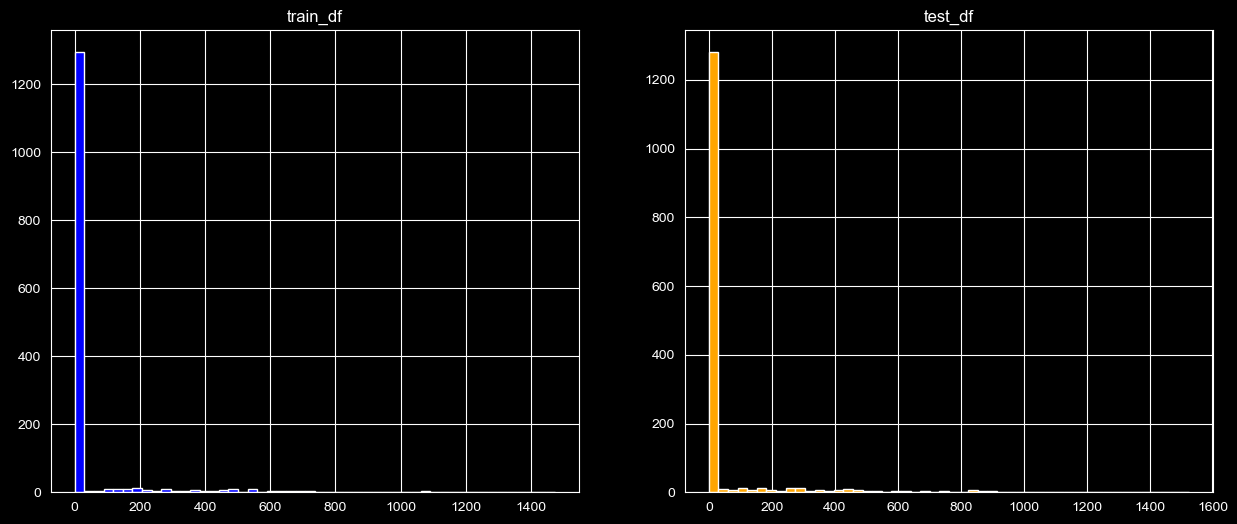

BsmtUnfSF
                      train_df      test_df
count              1460.000000  1458.000000
mean                567.240411   554.294925
std                 441.866955   437.260486
min                   0.000000     0.000000
25%                 223.000000   219.250000
50%                 477.500000   460.000000
75%                 808.000000   797.750000
max                2336.000000  2140.000000
per missing           0.000000     0.000685
numb outliers        29.000000          NaN
numb outliers iqr          NaN    26.000000


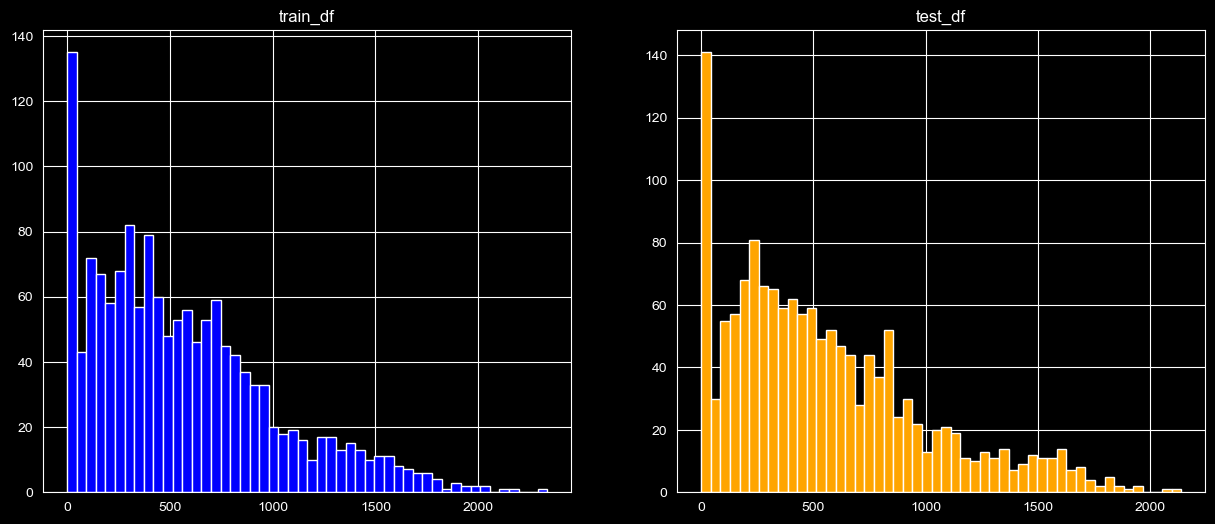

TotalBsmtSF
                      train_df      test_df
count              1460.000000  1458.000000
mean               1057.429452  1046.117970
std                 438.705324   442.898624
min                   0.000000     0.000000
25%                 795.750000   784.000000
50%                 991.500000   988.000000
75%                1298.250000  1305.000000
max                6110.000000  5095.000000
per missing           0.000000     0.000685
numb outliers        61.000000          NaN
numb outliers iqr          NaN    61.000000


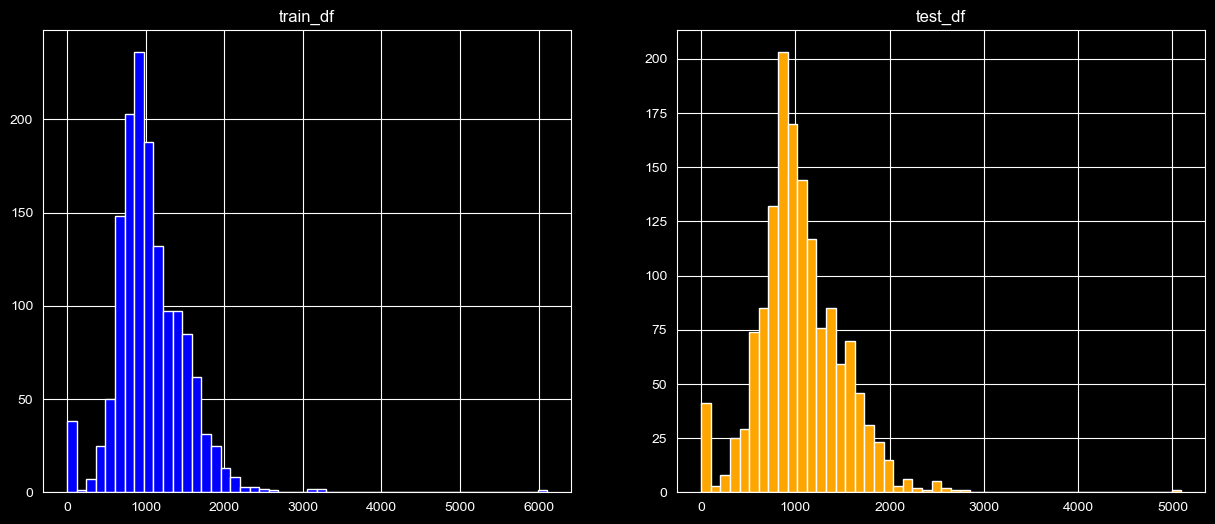

1stFlrSF
                      train_df      test_df
count              1460.000000  1459.000000
mean               1162.626712  1156.534613
std                 386.587738   398.165820
min                 334.000000   407.000000
25%                 882.000000   873.500000
50%                1087.000000  1079.000000
75%                1391.250000  1382.500000
max                4692.000000  5095.000000
per missing           0.000000     0.000000
numb outliers        20.000000          NaN
numb outliers iqr          NaN    23.000000


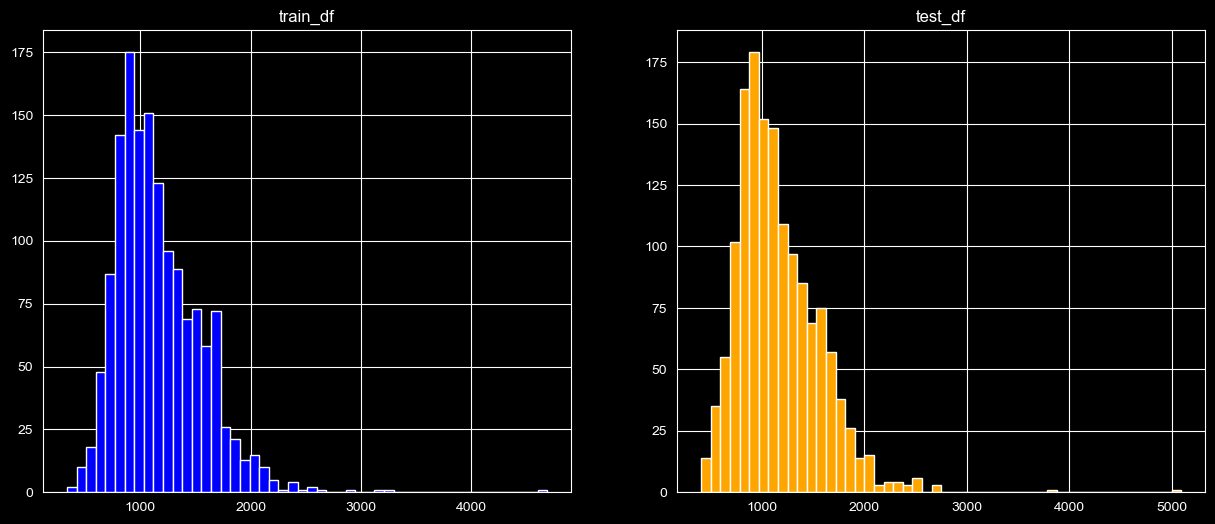

2ndFlrSF
                      train_df      test_df
count              1460.000000  1459.000000
mean                346.992466   325.967786
std                 436.528436   420.610226
min                   0.000000     0.000000
25%                   0.000000     0.000000
50%                   0.000000     0.000000
75%                 728.000000   676.000000
max                2065.000000  1862.000000
per missing           0.000000     0.000000
numb outliers         2.000000          NaN
numb outliers iqr          NaN     5.000000


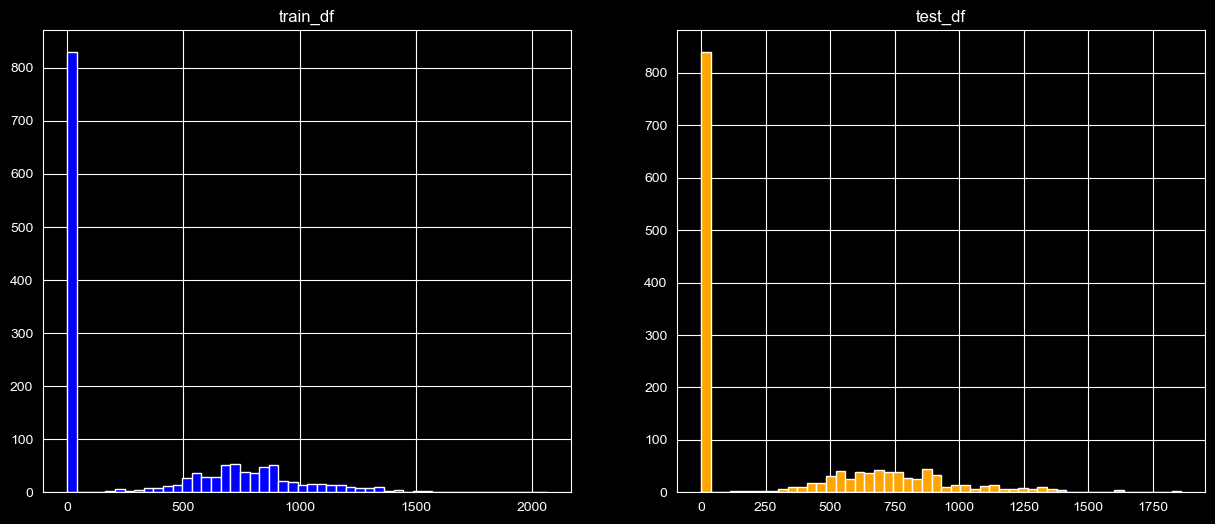

LowQualFinSF
                      train_df      test_df
count              1460.000000  1459.000000
mean                  5.844521     3.543523
std                  48.623081    44.043251
min                   0.000000     0.000000
25%                   0.000000     0.000000
50%                   0.000000     0.000000
75%                   0.000000     0.000000
max                 572.000000  1064.000000
per missing           0.000000     0.000000
numb outliers        26.000000          NaN
numb outliers iqr          NaN    14.000000


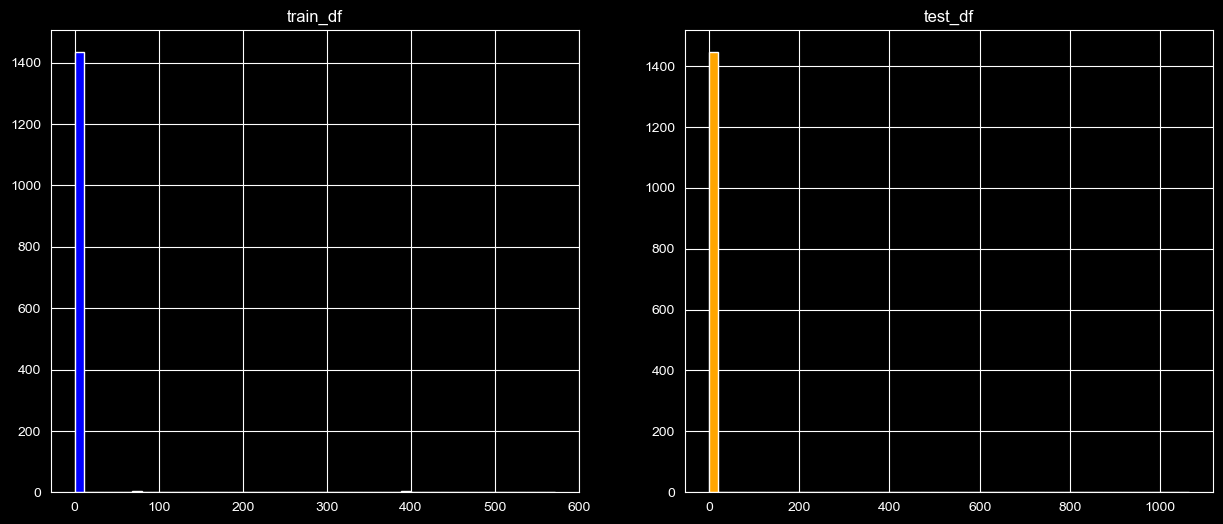

GrLivArea
                      train_df      test_df
count              1460.000000  1459.000000
mean               1515.463699  1486.045922
std                 525.480383   485.566099
min                 334.000000   407.000000
25%                1129.500000  1117.500000
50%                1464.000000  1432.000000
75%                1776.750000  1721.000000
max                5642.000000  5095.000000
per missing           0.000000     0.000000
numb outliers        31.000000          NaN
numb outliers iqr          NaN    44.000000


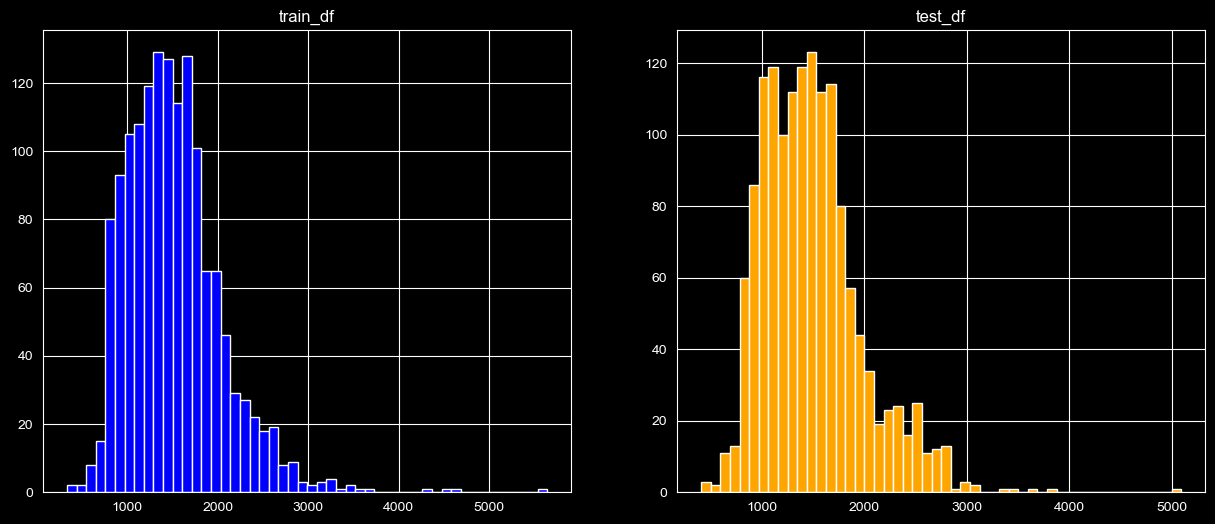

BsmtFullBath
                      train_df      test_df
count              1460.000000  1457.000000
mean                  0.425342     0.434454
std                   0.518911     0.530648
min                   0.000000     0.000000
25%                   0.000000     0.000000
50%                   0.000000     0.000000
75%                   1.000000     1.000000
max                   3.000000     3.000000
per missing           0.000000     0.001371
numb outliers         1.000000          NaN
numb outliers iqr          NaN     1.000000


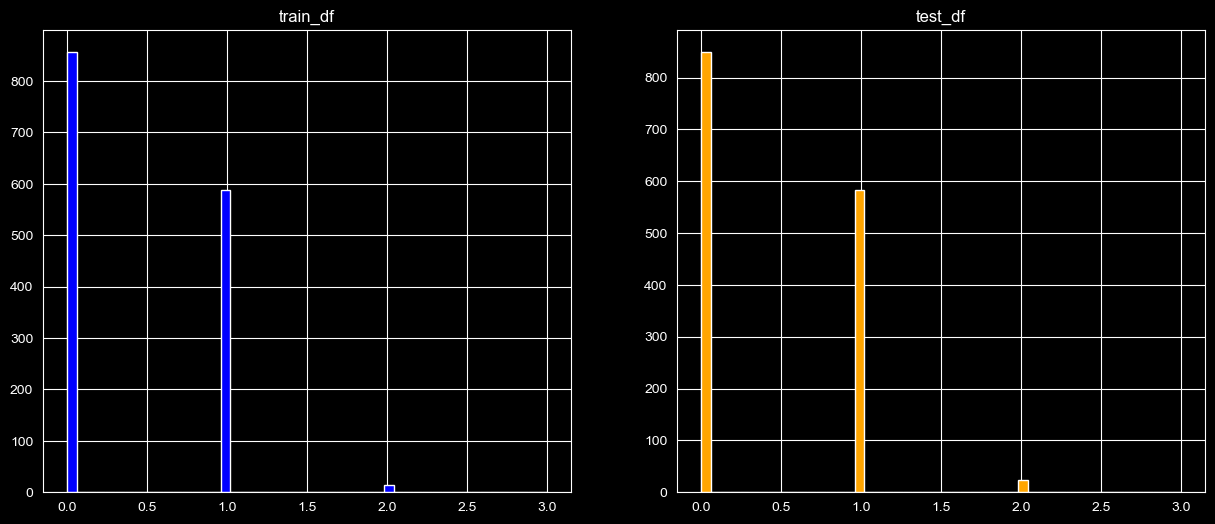

BsmtHalfBath
                      train_df      test_df
count              1460.000000  1457.000000
mean                  0.057534     0.065202
std                   0.238753     0.252468
min                   0.000000     0.000000
25%                   0.000000     0.000000
50%                   0.000000     0.000000
75%                   0.000000     0.000000
max                   2.000000     2.000000
per missing           0.000000     0.001371
numb outliers        82.000000          NaN
numb outliers iqr          NaN    93.000000


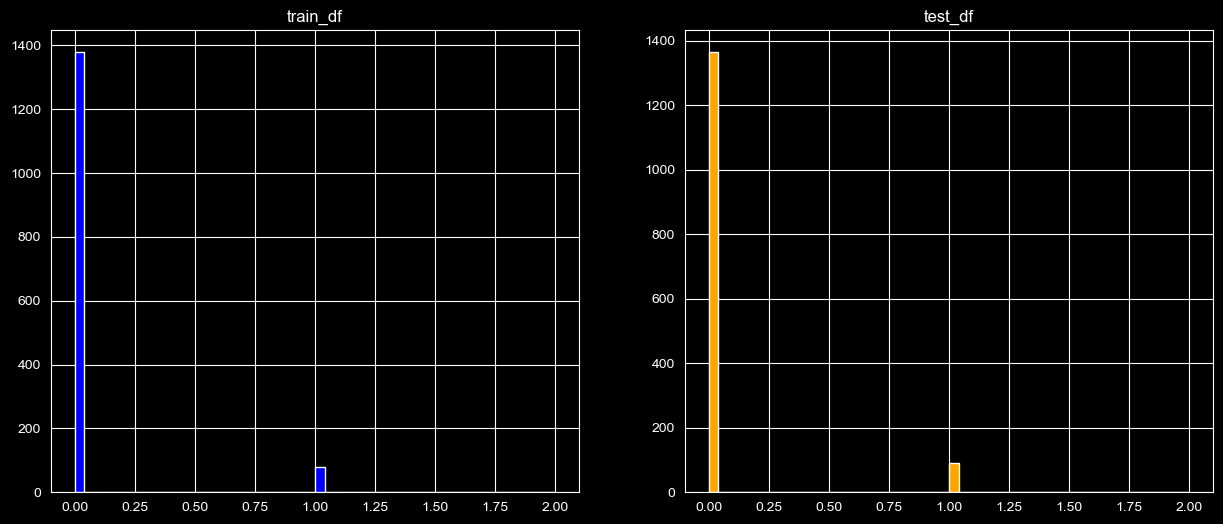

FullBath
                      train_df      test_df
count              1460.000000  1459.000000
mean                  1.565068     1.570939
std                   0.550916     0.555190
min                   0.000000     0.000000
25%                   1.000000     1.000000
50%                   2.000000     2.000000
75%                   2.000000     2.000000
max                   3.000000     4.000000
per missing           0.000000     0.000000
numb outliers         0.000000          NaN
numb outliers iqr          NaN     4.000000


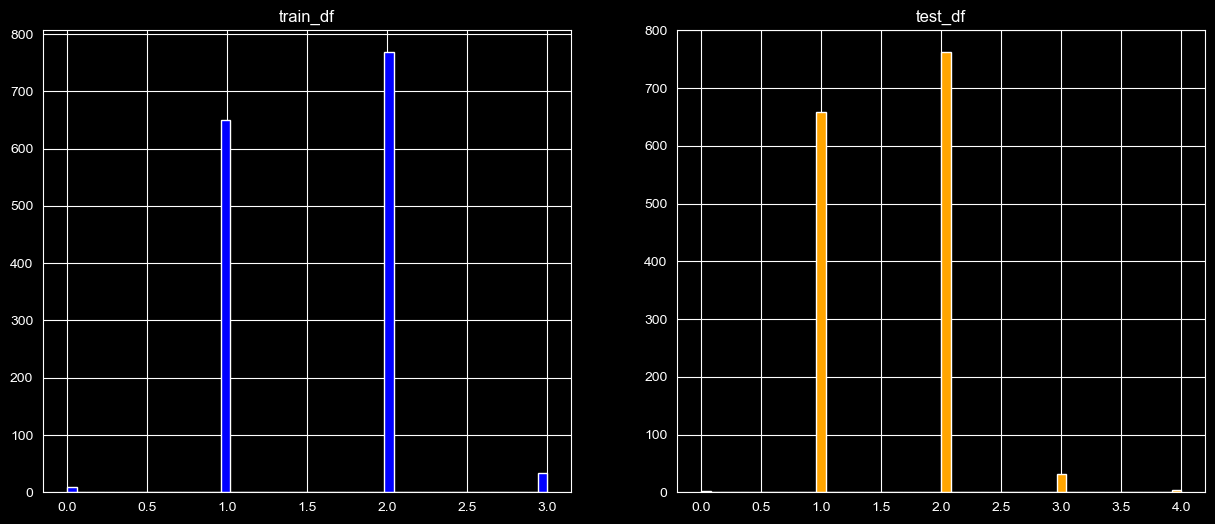

HalfBath
                      train_df      test_df
count              1460.000000  1459.000000
mean                  0.382877     0.377656
std                   0.502885     0.503017
min                   0.000000     0.000000
25%                   0.000000     0.000000
50%                   0.000000     0.000000
75%                   1.000000     1.000000
max                   2.000000     2.000000
per missing           0.000000     0.000000
numb outliers         0.000000          NaN
numb outliers iqr          NaN     0.000000


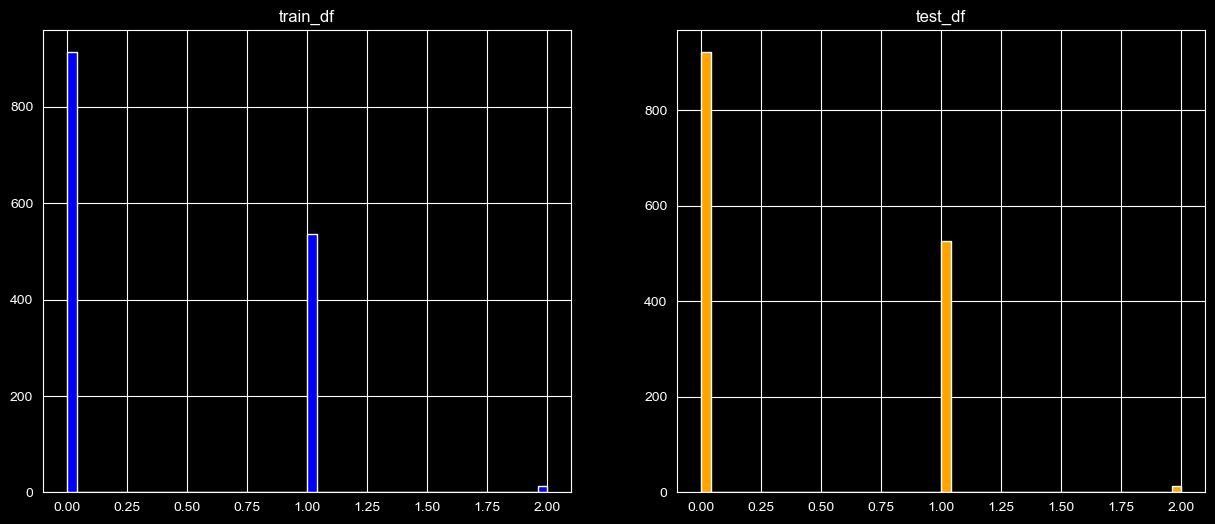

BedroomAbvGr
                      train_df      test_df
count              1460.000000  1459.000000
mean                  2.866438     2.854010
std                   0.815778     0.829788
min                   0.000000     0.000000
25%                   2.000000     2.000000
50%                   3.000000     3.000000
75%                   3.000000     3.000000
max                   8.000000     6.000000
per missing           0.000000     0.000000
numb outliers        35.000000          NaN
numb outliers iqr          NaN    43.000000


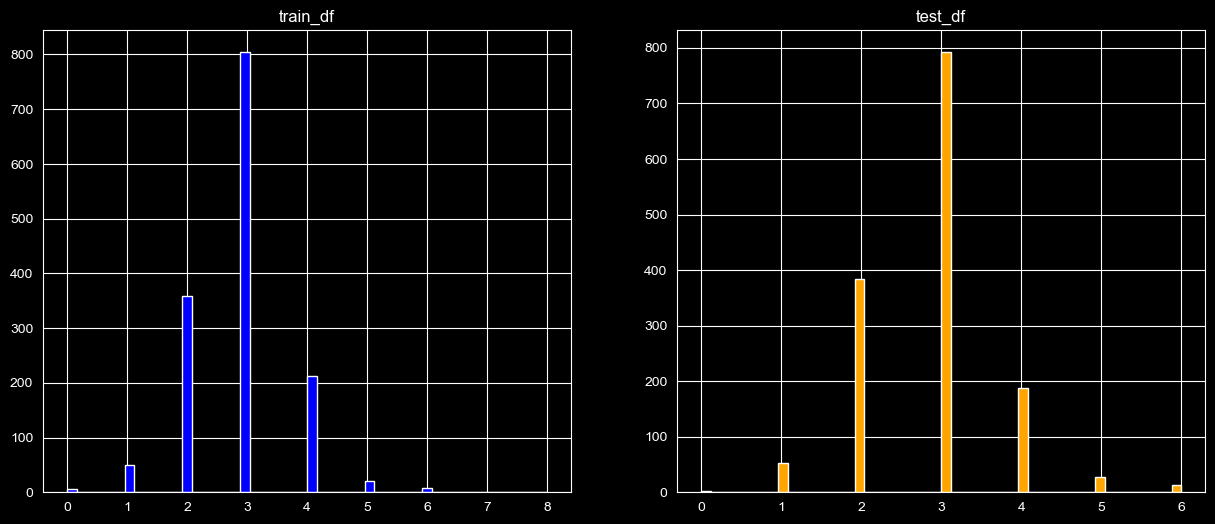

KitchenAbvGr
                      train_df      test_df
count              1460.000000  1459.000000
mean                  1.046575     1.042495
std                   0.220338     0.208472
min                   0.000000     0.000000
25%                   1.000000     1.000000
50%                   1.000000     1.000000
75%                   1.000000     1.000000
max                   3.000000     2.000000
per missing           0.000000     0.000000
numb outliers        68.000000          NaN
numb outliers iqr          NaN    66.000000


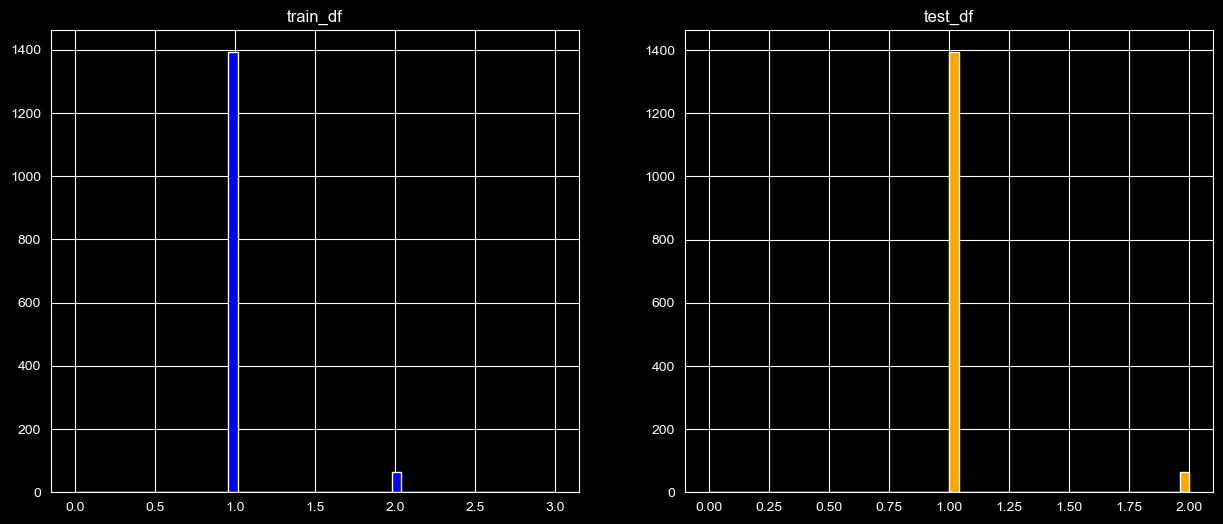

TotRmsAbvGrd
                      train_df      test_df
count              1460.000000  1459.000000
mean                  6.517808     6.385195
std                   1.625393     1.508895
min                   2.000000     3.000000
25%                   5.000000     5.000000
50%                   6.000000     6.000000
75%                   7.000000     7.000000
max                  14.000000    15.000000
per missing           0.000000     0.000000
numb outliers        30.000000          NaN
numb outliers iqr          NaN    21.000000


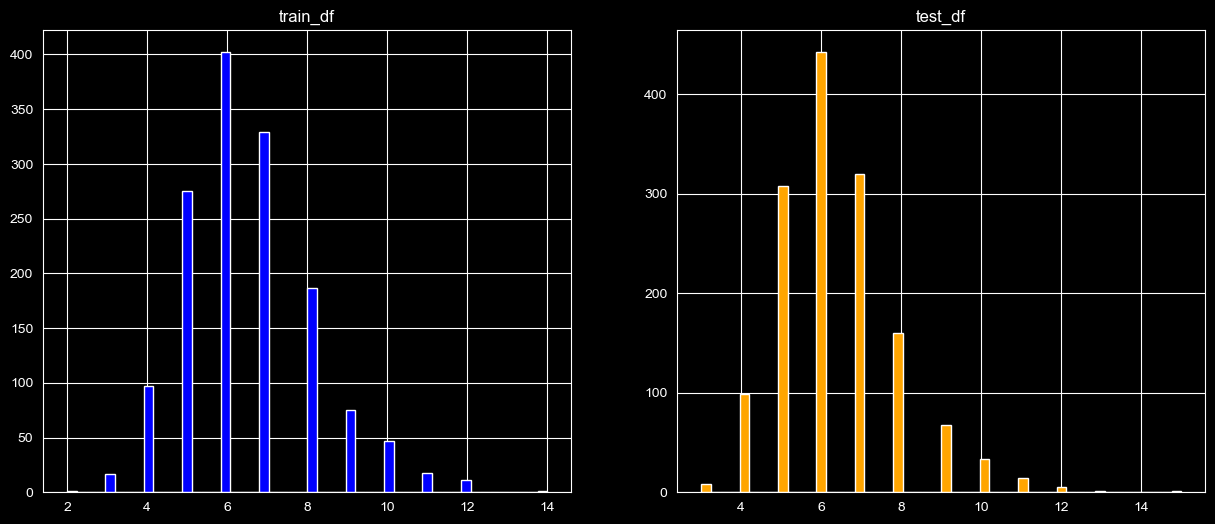

Fireplaces
                      train_df     test_df
count              1460.000000  1459.00000
mean                  0.613014     0.58122
std                   0.644666     0.64742
min                   0.000000     0.00000
25%                   0.000000     0.00000
50%                   1.000000     0.00000
75%                   1.000000     1.00000
max                   3.000000     4.00000
per missing           0.000000     0.00000
numb outliers         5.000000         NaN
numb outliers iqr          NaN     7.00000


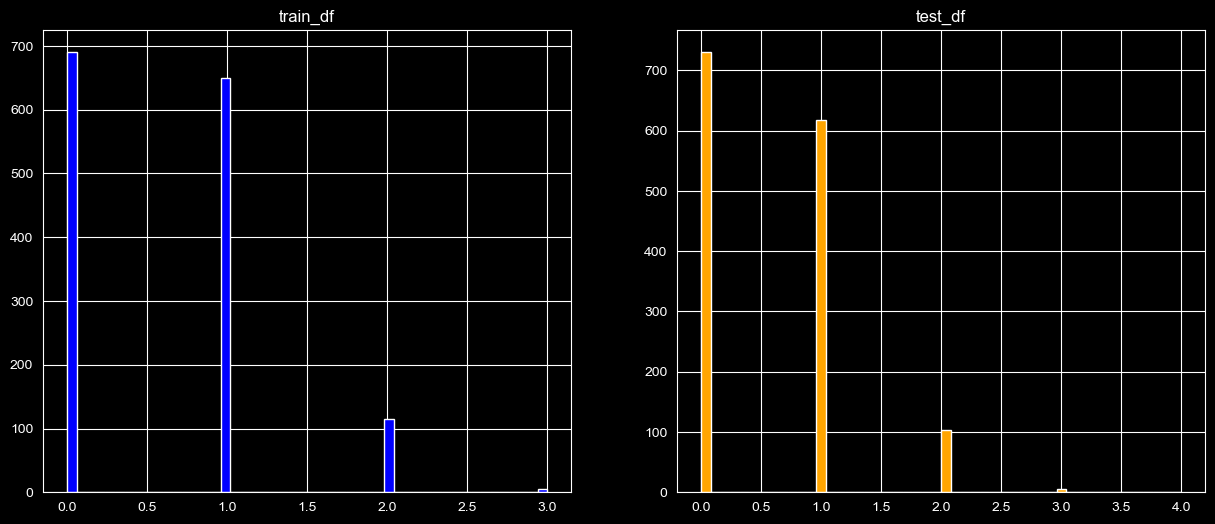

GarageYrBlt
                      train_df      test_df
count              1379.000000  1381.000000
mean               1978.506164  1977.721217
std                  24.689725    26.431175
min                1900.000000  1895.000000
25%                1961.000000  1959.000000
50%                1980.000000  1979.000000
75%                2002.000000  2002.000000
max                2010.000000  2207.000000
per missing           0.055479     0.053461
numb outliers         0.000000          NaN
numb outliers iqr          NaN     1.000000


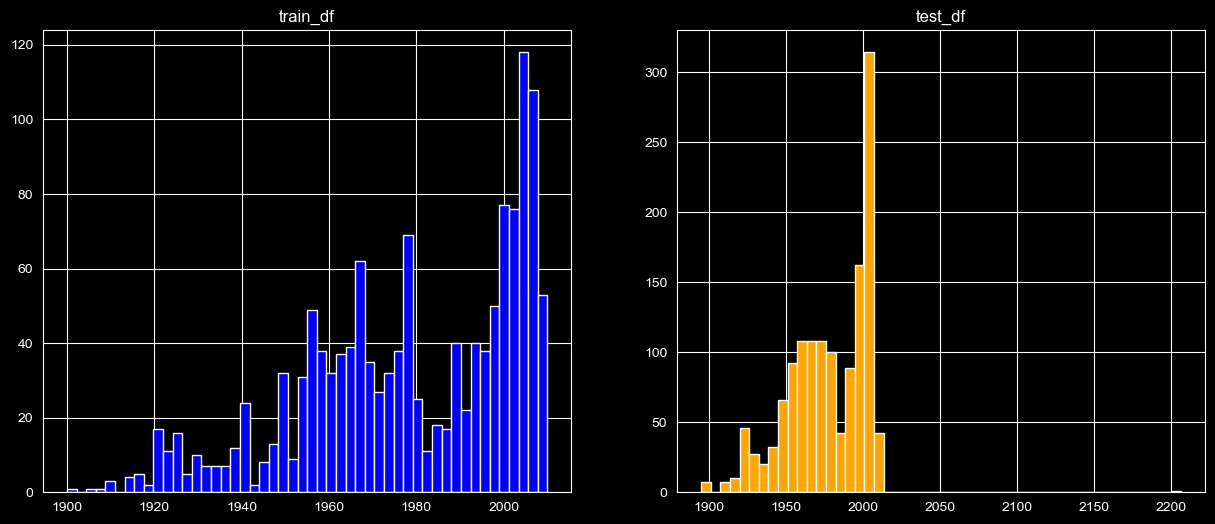

GarageCars
                      train_df      test_df
count              1460.000000  1458.000000
mean                  1.767123     1.766118
std                   0.747315     0.775945
min                   0.000000     0.000000
25%                   1.000000     1.000000
50%                   2.000000     2.000000
75%                   2.000000     2.000000
max                   4.000000     5.000000
per missing           0.000000     0.000685
numb outliers         5.000000          NaN
numb outliers iqr          NaN    12.000000


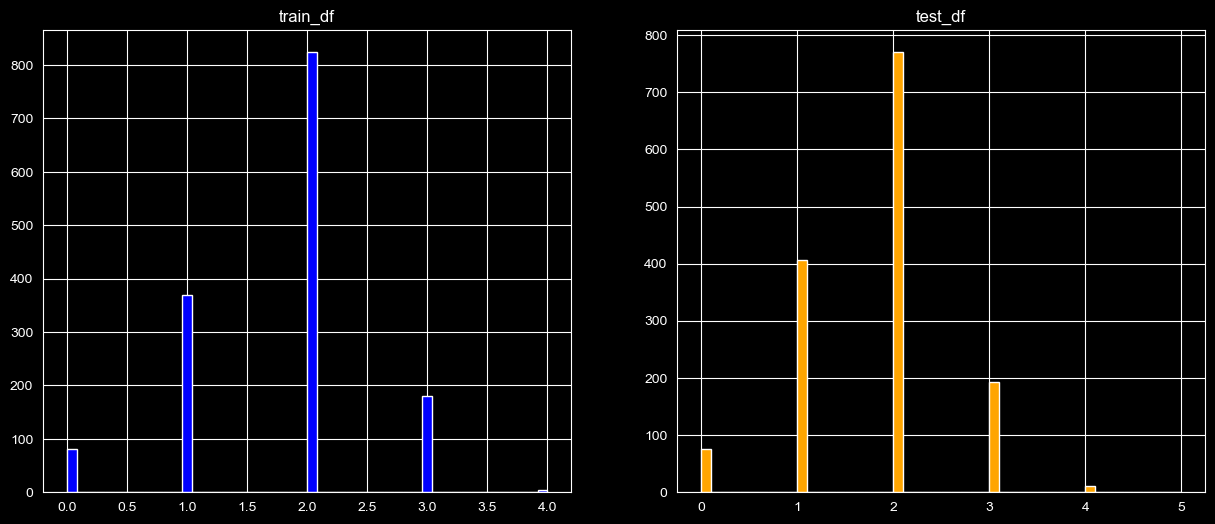

GarageArea
                      train_df      test_df
count              1460.000000  1458.000000
mean                472.980137   472.768861
std                 213.804841   217.048611
min                   0.000000     0.000000
25%                 334.500000   318.000000
50%                 480.000000   480.000000
75%                 576.000000   576.000000
max                1418.000000  1488.000000
per missing           0.000000     0.000685
numb outliers        21.000000          NaN
numb outliers iqr          NaN    21.000000


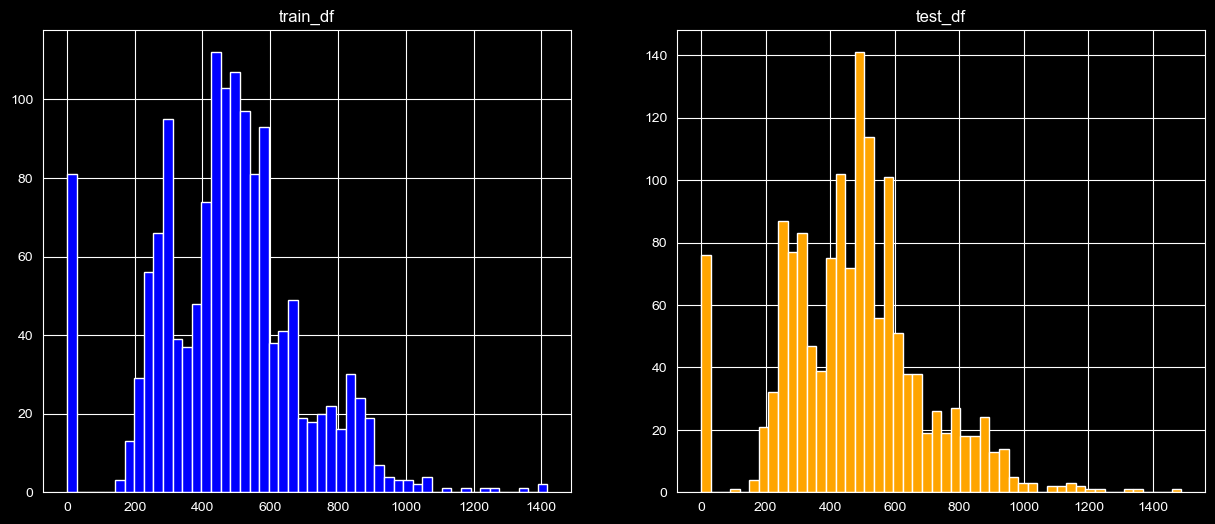

WoodDeckSF
                      train_df      test_df
count              1460.000000  1459.000000
mean                 94.244521    93.174777
std                 125.338794   127.744882
min                   0.000000     0.000000
25%                   0.000000     0.000000
50%                   0.000000     0.000000
75%                 168.000000   168.000000
max                 857.000000  1424.000000
per missing           0.000000     0.000000
numb outliers        32.000000          NaN
numb outliers iqr          NaN    35.000000


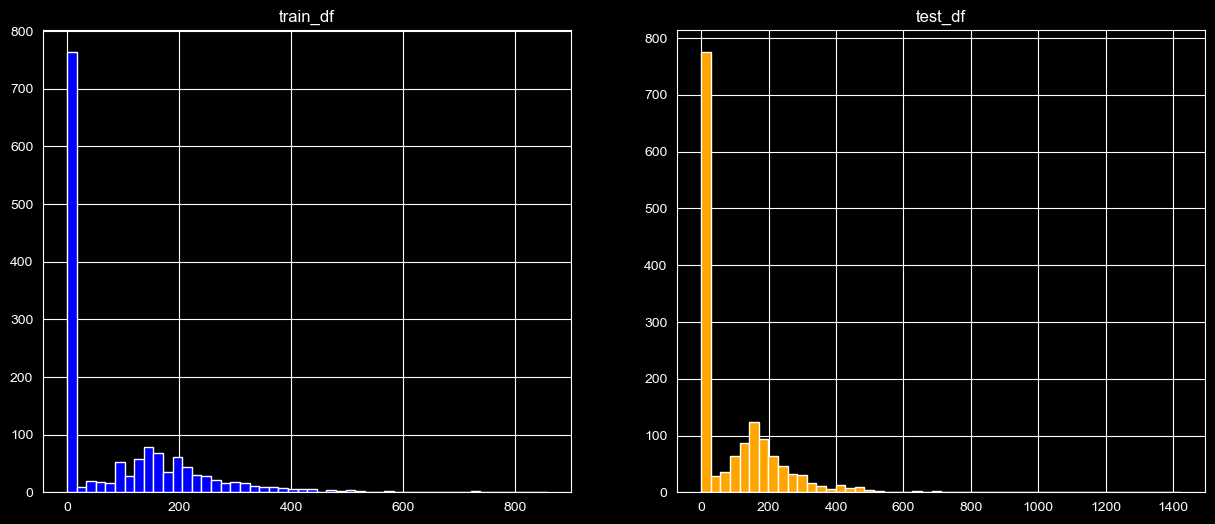

OpenPorchSF
                      train_df      test_df
count              1460.000000  1459.000000
mean                 46.660274    48.313914
std                  66.256028    68.883364
min                   0.000000     0.000000
25%                   0.000000     0.000000
50%                  25.000000    28.000000
75%                  68.000000    72.000000
max                 547.000000   742.000000
per missing           0.000000     0.000000
numb outliers        77.000000          NaN
numb outliers iqr          NaN    79.000000


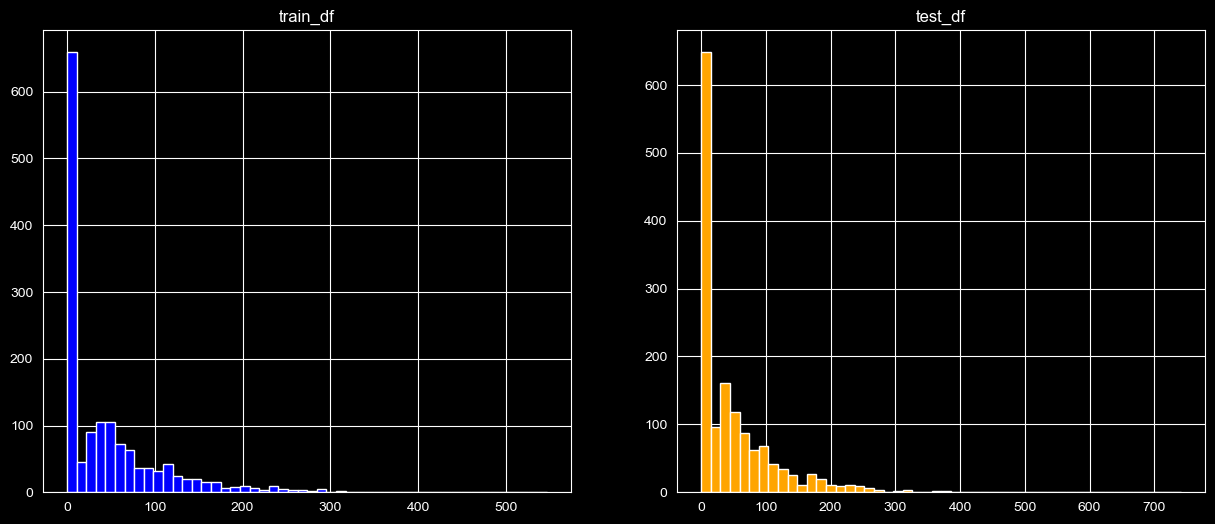

EnclosedPorch
                      train_df      test_df
count              1460.000000  1459.000000
mean                 21.954110    24.243317
std                  61.119149    67.227765
min                   0.000000     0.000000
25%                   0.000000     0.000000
50%                   0.000000     0.000000
75%                   0.000000     0.000000
max                 552.000000  1012.000000
per missing           0.000000     0.000000
numb outliers       208.000000          NaN
numb outliers iqr          NaN   251.000000


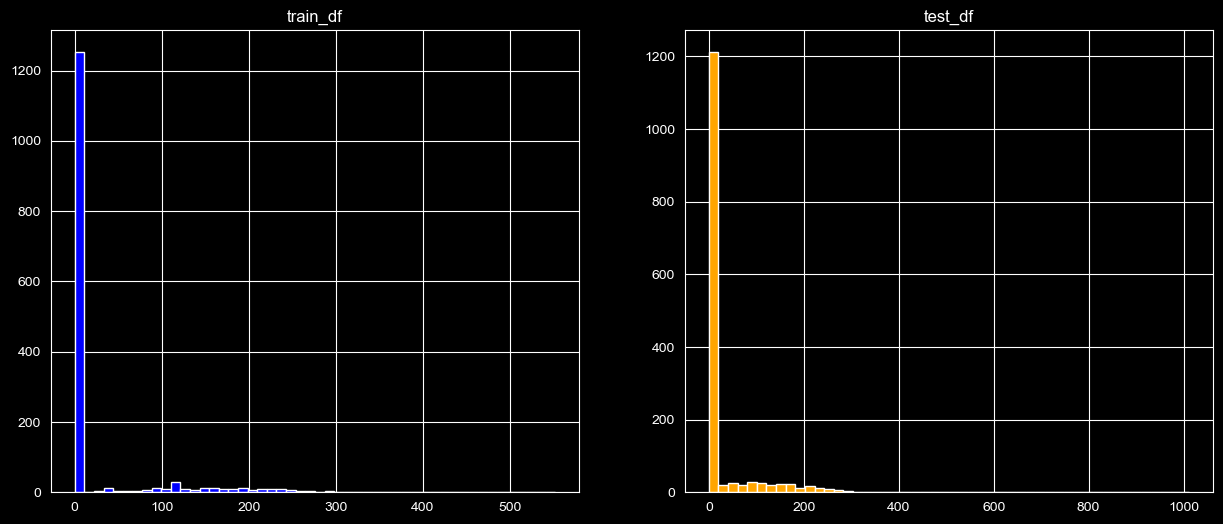

3SsnPorch
                      train_df      test_df
count              1460.000000  1459.000000
mean                  3.409589     1.794380
std                  29.317331    20.207842
min                   0.000000     0.000000
25%                   0.000000     0.000000
50%                   0.000000     0.000000
75%                   0.000000     0.000000
max                 508.000000   360.000000
per missing           0.000000     0.000000
numb outliers        24.000000          NaN
numb outliers iqr          NaN    13.000000


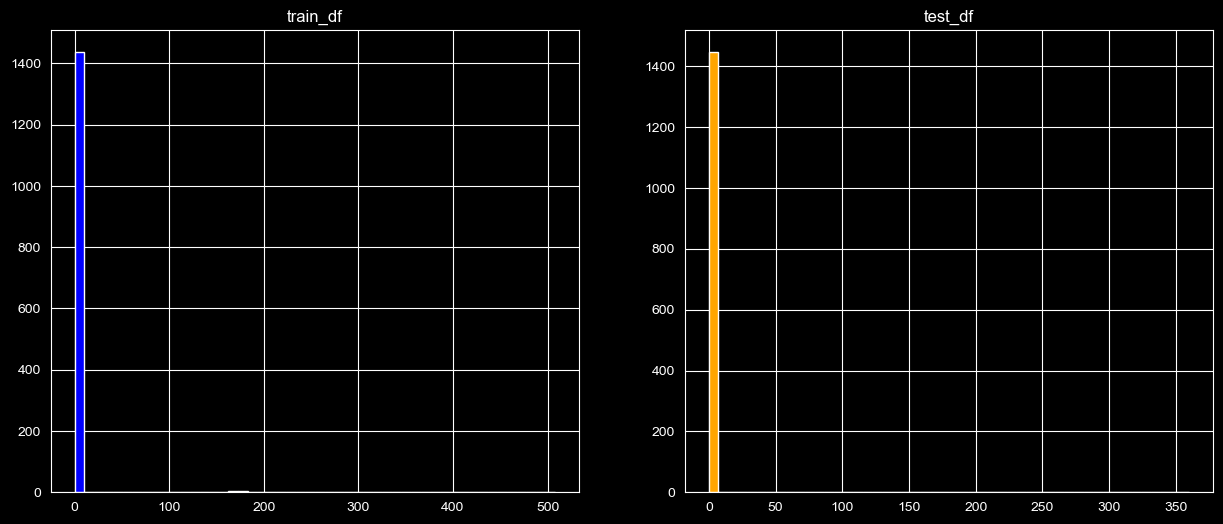

ScreenPorch
                      train_df      test_df
count              1460.000000  1459.000000
mean                 15.060959    17.064428
std                  55.757415    56.609763
min                   0.000000     0.000000
25%                   0.000000     0.000000
50%                   0.000000     0.000000
75%                   0.000000     0.000000
max                 480.000000   576.000000
per missing           0.000000     0.000000
numb outliers       116.000000          NaN
numb outliers iqr          NaN   140.000000


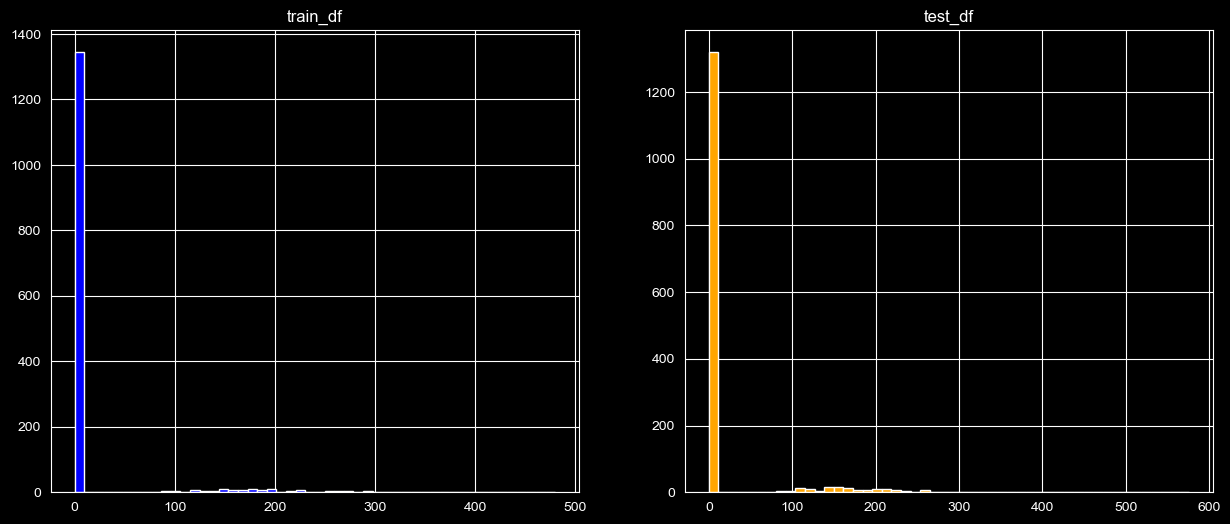

PoolArea
                      train_df      test_df
count              1460.000000  1459.000000
mean                  2.758904     1.744345
std                  40.177307    30.491646
min                   0.000000     0.000000
25%                   0.000000     0.000000
50%                   0.000000     0.000000
75%                   0.000000     0.000000
max                 738.000000   800.000000
per missing           0.000000     0.000000
numb outliers         7.000000          NaN
numb outliers iqr          NaN     6.000000


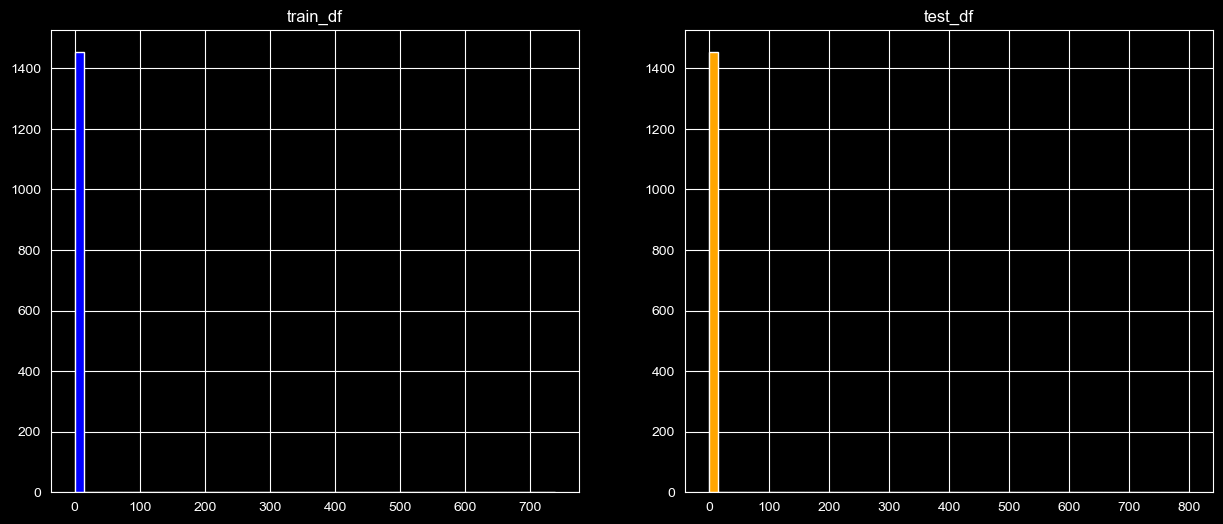

MiscVal
                       train_df       test_df
count               1460.000000   1459.000000
mean                  43.489041     58.167923
std                  496.123024    630.806978
min                    0.000000      0.000000
25%                    0.000000      0.000000
50%                    0.000000      0.000000
75%                    0.000000      0.000000
max                15500.000000  17000.000000
per missing            0.000000      0.000000
numb outliers         52.000000           NaN
numb outliers iqr           NaN     51.000000


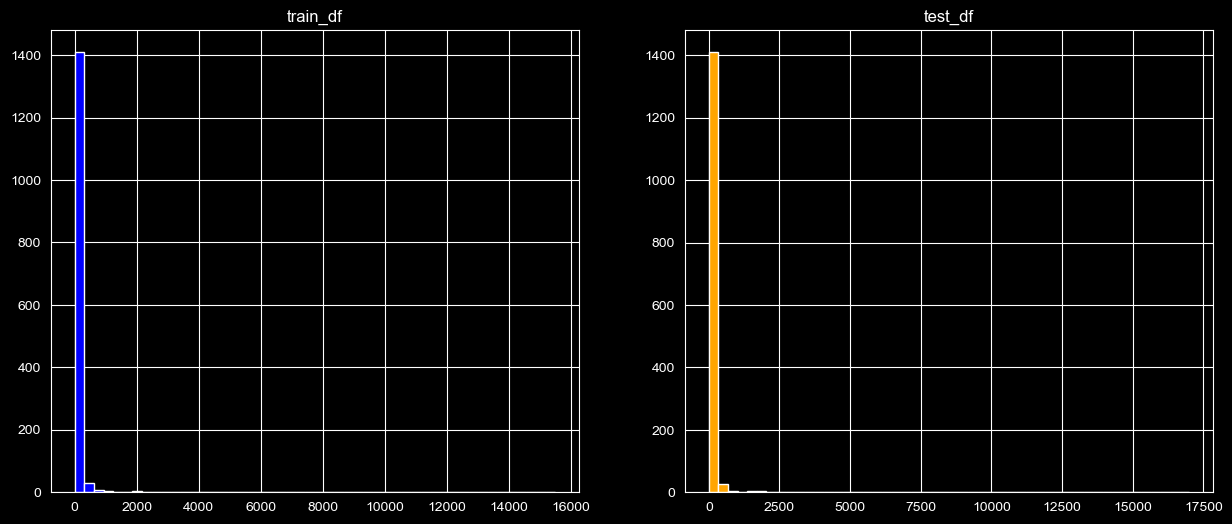

In [17]:
for num_col in num_cols:
    print(num_col)
    print(describe_col(num_col))
    plot_multi_hist(train_df, test_df, num_col, 'train_df', 'test_df', bins=50)

The IQR method detected outliers in multiple parameters. In many cases, the outliers are due to a long tail. In some cases, the values are zero, so any nonzero value is deemed an outlier. There are some errors in the dataset. For example, there is a garage year built which is in the future.

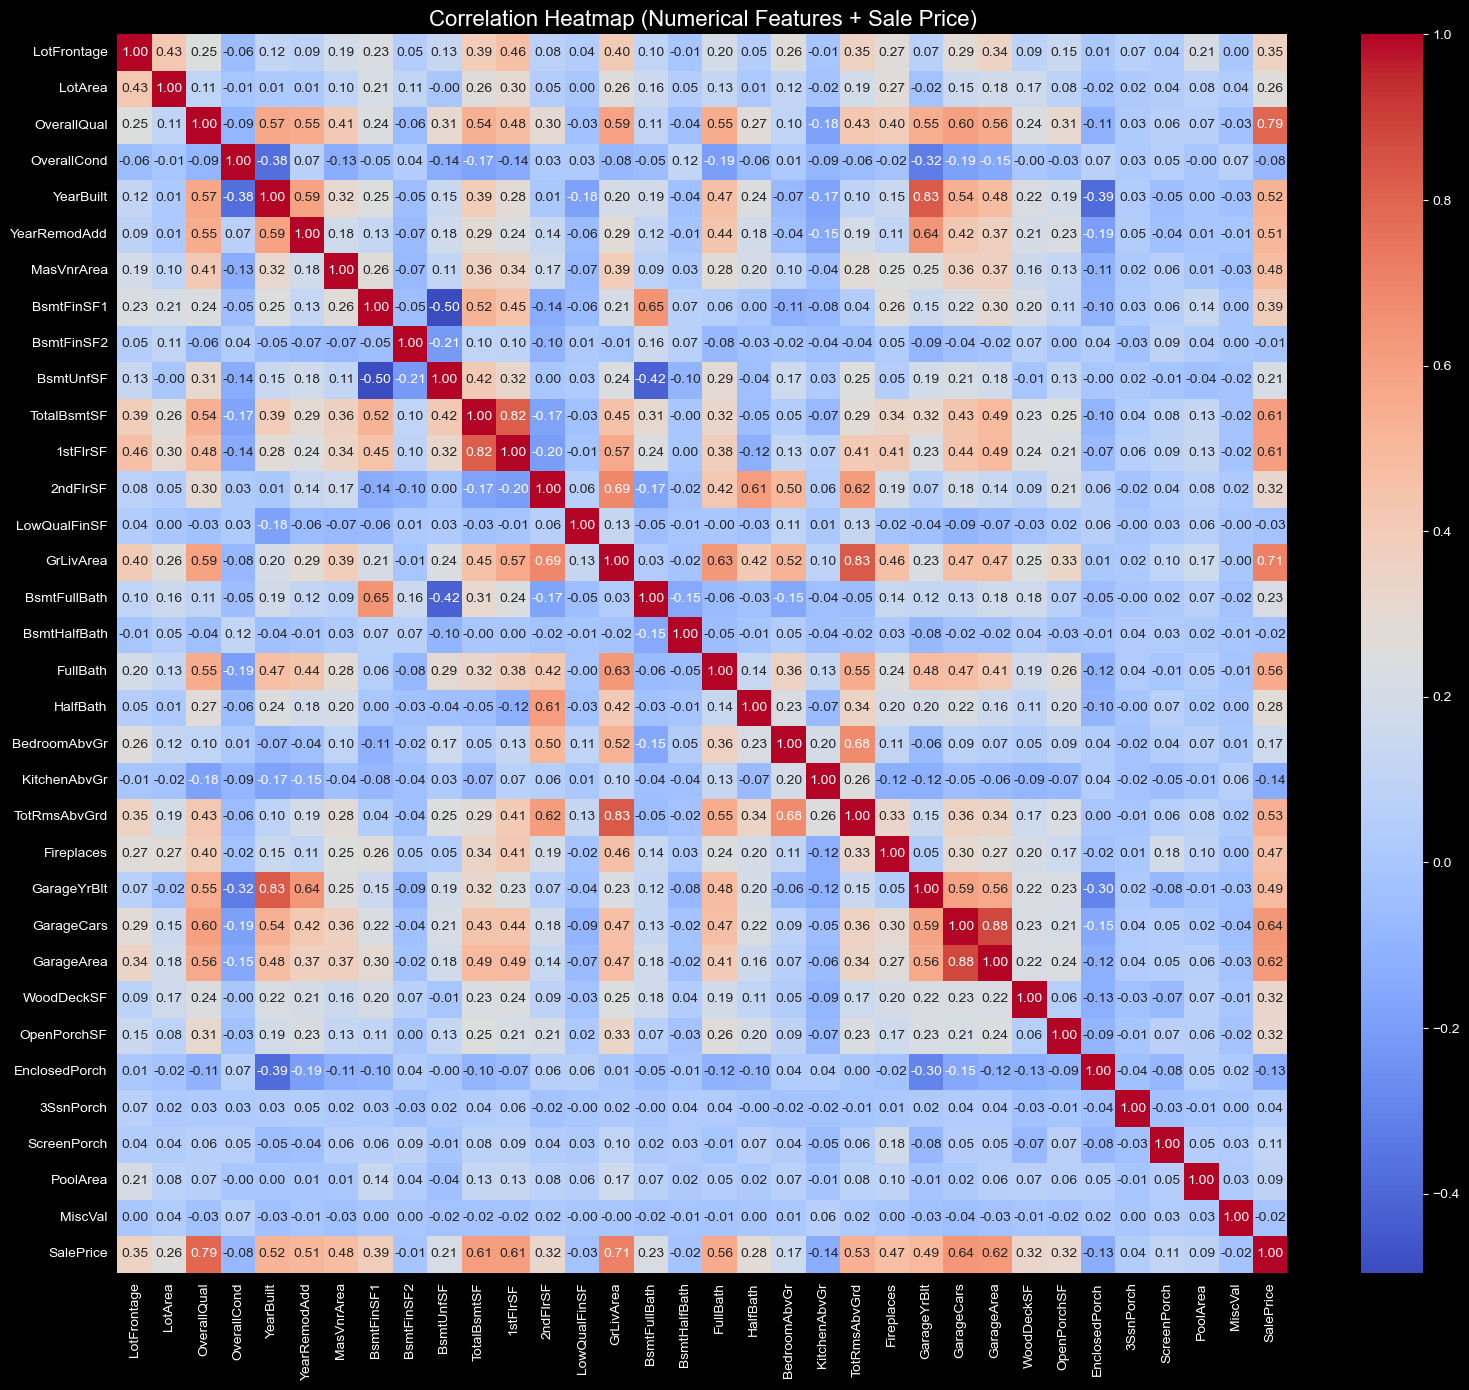

In [18]:
# Compute correlation matrix
corr_matrix = pd.concat([train_df[num_cols],train_df['SalePrice']],axis=1).corr()


# Plot heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap (Numerical Features + Sale Price)', fontsize=16)
plt.tight_layout()
plt.show()

Before modifying the data, a baseline model will be run to determine model performance. Changes will be compared to the baseline model.

Mean: 0.14847745092919595
Std: 0.005966080838505925


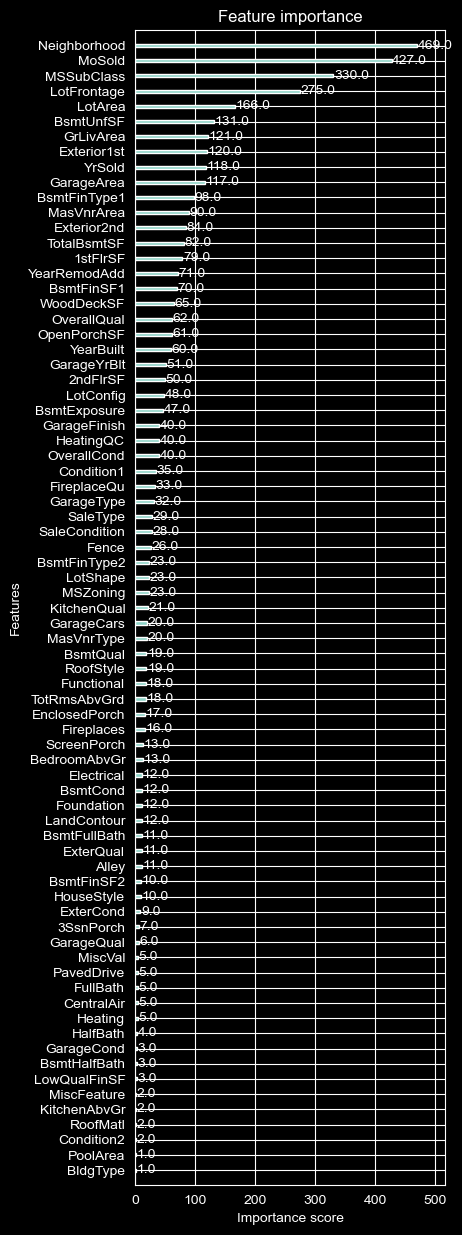

In [19]:
default_xgb_params = {
    "objective": "reg:squarederror",
    "seed": RANDOM_STATE,
    'enable_categorical': True,
    'early_stopping': 20,
    'n_estimators': 100,
    'eval_metric': 'rmse'
}

def run_xgb(X,y, X_test, params):

    cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    rsme_vals = []
    test_preds = []
    for train_idx, valid_idx in cv.split(X, y):
        model = xgb.XGBRegressor(**params)
        model.fit(
            X.iloc[train_idx], y.iloc[train_idx],
            eval_set=[(X.iloc[valid_idx], y.iloc[valid_idx])],
            verbose=False
        )
        preds = model.predict(X.iloc[valid_idx])
        rsme_vals.append(np.sqrt(mean_squared_error(y.iloc[valid_idx], preds)))
        prediction = model.predict(X_test)
        test_preds.append(prediction)
    print("Mean:", np.mean(rsme_vals))
    print("Std:", np.std(rsme_vals))


    fig, ax = plt.subplots(figsize=(4, 15))
    xgb.plot_importance(model, ax=ax)
    plt.show()
    return test_preds

basic_model_train_df = train_df.copy()
basic_model_test_df = test_df.copy()

basic_model_train_df[cat_cols] = basic_model_train_df[cat_cols].astype('category')
basic_model_test_df[cat_cols] = basic_model_test_df[cat_cols].astype('category')

predictions = run_xgb(basic_model_train_df.drop(columns=['SalePrice']),
                      np.log(basic_model_train_df['SalePrice']),
                      basic_model_test_df.drop(columns=['Id']),
                      default_xgb_params)

In [20]:
def create_submission(preds):
    preds = np.column_stack(preds)
    final_pred = preds.mean(axis=1)
    # Build submission
    submission = pd.DataFrame({
        'Id': test_df['Id'].values,
        'SalePrice': np.exp(final_pred)
    })

    out_path = "submission.csv"
    submission.to_csv(out_path, index=False)

In [21]:
create_submission(predictions)

Start to fill in the missing values. For objects that do not exist, replace NaN with 'None'.

In [22]:
train_df.loc[train_df['PoolArea'] == 0, 'PoolQC'] = 'None'
test_df.loc[test_df['PoolArea'] == 0, 'PoolQC'] = 'None'

train_df.loc[train_df['MiscVal']==0, 'MiscFeature'] = 'None'
test_df.loc[test_df['MiscVal']==0, 'MiscFeature'] = 'None'

train_df.loc[train_df['Alley'].isna(), 'Alley'] = 'None'
test_df.loc[test_df['Alley'].isna(), 'Alley'] = 'None'

train_df.loc[train_df['Fence'].isna(), 'Fence'] = 'None'
test_df.loc[test_df['Fence'].isna(), 'Fence'] = 'None'


train_df.loc[train_df['Fireplaces']==0, 'FireplaceQu'] = 'None'
test_df.loc[test_df['Fireplaces']==0, 'FireplaceQu'] = 'None'

train_df.loc[train_df['GarageArea']==0, ['GarageFinish', 'GarageType','GarageQual',
                                         'GarageCond']] = 'None'
test_df.loc[test_df['GarageArea']==0, ['GarageFinish', 'GarageType','GarageQual',
                                       'GarageCond']] = 'None'

train_df.loc[train_df['BsmtFinSF1'] == 0, 'BsmtFinType1'] = 'None'
test_df.loc[test_df['BsmtFinSF1'] == 0, 'BsmtFinType1'] = 'None'


train_df.loc[train_df['BsmtFinSF2'] == 0, 'BsmtFinType2'] = 'None'
test_df.loc[test_df['BsmtFinSF2'] == 0, 'BsmtFinType2'] = 'None'
""" - Without this causes an error occurs in xgboost because test set has Unf while train set does not """
test_df.loc[test_df['BsmtFinType2'] == 'Unf', 'BsmtFinType2'] = 'None'

train_df.loc[train_df['MasVnrArea'] == 0, 'MasVnrType'] = 'None'
test_df.loc[test_df['MasVnrArea'] == 0, 'MasVnrType'] = 'None'


train_df.loc[train_df['TotalBsmtSF'] == 0, ['BsmtCond', 'BsmtQual', 'BsmtExposure']] = 'None'
test_df.loc[test_df['TotalBsmtSF'] == 0, ['BsmtCond', 'BsmtQual', 'BsmtExposure']] = 'None'


In [23]:
print("Missing data in train_df:")
print(missing_data_table(train_df))
print("Missing data in test_df:")
print(missing_data_table(test_df))

Missing data in train_df:
              Total   Percent
LotFrontage     259  0.177397
GarageYrBlt      81  0.055479
MasVnrType       13  0.008904
MasVnrArea        8  0.005479
BsmtExposure      1  0.000685
Electrical        1  0.000685
BsmtFinType2      1  0.000685
Missing data in test_df:
              Total   Percent
LotFrontage     227  0.155586
GarageYrBlt      78  0.053461
MasVnrType       18  0.012337
MasVnrArea       15  0.010281
MSZoning          4  0.002742
BsmtCond          4  0.002742
BsmtQual          3  0.002056
BsmtExposure      3  0.002056
PoolQC            3  0.002056
Utilities         2  0.001371
Functional        2  0.001371
BsmtFullBath      2  0.001371
GarageCond        2  0.001371
GarageQual        2  0.001371
GarageFinish      2  0.001371
BsmtHalfBath      2  0.001371
BsmtFinSF2        1  0.000685
BsmtUnfSF         1  0.000685
BsmtFinType2      1  0.000685
BsmtFinSF1        1  0.000685
BsmtFinType1      1  0.000685
TotalBsmtSF       1  0.000685
KitchenQual       1

There is a GarageYrBuilt which is in the future. Check the year columns and set any future years to np.nan.

In [24]:
train_df.loc[train_df['GarageYrBlt'] > 2010, 'GarageYrBlt'] = np.nan
train_df.loc[train_df['YearBuilt'] > 2010, 'YearBuilt'] = np.nan
train_df.loc[train_df['YearRemodAdd'] > 2010, 'YearRemodAdd'] = np.nan
train_df.loc[train_df['YrSold'] > 2010, 'YrSold'] = np.nan

test_df.loc[test_df['GarageYrBlt'] > 2010, 'GarageYrBlt'] = np.nan
test_df.loc[test_df['YearBuilt'] > 2010, 'YearBuilt'] = np.nan
test_df.loc[test_df['YearRemodAdd'] > 2010, 'YearRemodAdd'] = np.nan
test_df.loc[test_df['YrSold'] > 2010, 'YrSold'] = np.nan

In [25]:
print("Missing data in train_df:")
print(missing_data_table(train_df))
print("Missing data in test_df:")
print(missing_data_table(test_df))

Missing data in train_df:
              Total   Percent
LotFrontage     259  0.177397
GarageYrBlt      81  0.055479
MasVnrType       13  0.008904
MasVnrArea        8  0.005479
BsmtExposure      1  0.000685
Electrical        1  0.000685
BsmtFinType2      1  0.000685
Missing data in test_df:
              Total   Percent
LotFrontage     227  0.155586
GarageYrBlt      79  0.054147
MasVnrType       18  0.012337
MasVnrArea       15  0.010281
MSZoning          4  0.002742
BsmtCond          4  0.002742
BsmtQual          3  0.002056
BsmtExposure      3  0.002056
PoolQC            3  0.002056
Utilities         2  0.001371
Functional        2  0.001371
BsmtFullBath      2  0.001371
GarageCond        2  0.001371
GarageQual        2  0.001371
GarageFinish      2  0.001371
BsmtHalfBath      2  0.001371
BsmtFinSF2        1  0.000685
BsmtUnfSF         1  0.000685
BsmtFinType2      1  0.000685
BsmtFinSF1        1  0.000685
BsmtFinType1      1  0.000685
TotalBsmtSF       1  0.000685
KitchenQual       1

There are four columns in the train dataset that have missing values: MasVnrType, LotFrontage, GarageYrBl, MasVnrArea and Electricl. Looking at data description, MasVnrType is categorical and uses None to indicate no masonry veneer. Therefore, this column will not be imputed. LotFrontage, GarageYrBlt and MasVnrArea are numerical columns and will need to be imputed.

There are 19 columns in the test dataset that have missing values. For the numerical columns, I will impute using the median value. For the categorical columns, I will impute using the mode.

Check PoolQC due to the high number of NaNs

In [26]:
print(train_df[train_df['PoolArea'] == 0]['PoolQC'].value_counts(dropna=False))
print(train_df[train_df['PoolArea'] != 0]['PoolQC'].value_counts(dropna=False))
print(len(train_df[train_df['PoolArea'] != 0]))

PoolQC
None    1453
Name: count, dtype: int64
PoolQC
Gd    3
Ex    2
Fa    2
Name: count, dtype: int64
7


The high number of NaNs is due to very few houses having a pool.

In most cases, the garage and house should be built at the same time. Let's check if that is true in the data.

<Axes: >

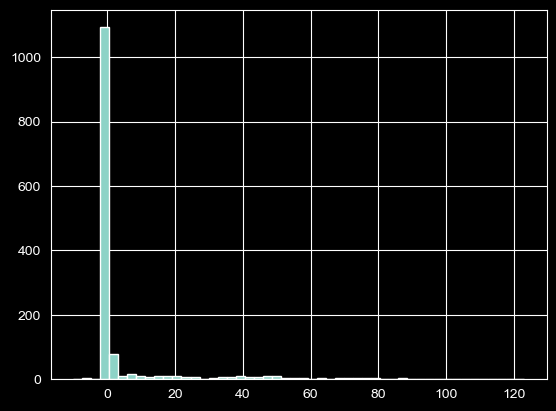

In [27]:
dif_gar_house_built = train_df['GarageYrBlt'] - train_df['YearBuilt']
dif_gar_house_built.hist(bins=50)

Assume that the lots are square so that lot frontage is the sqrt of the lot area.

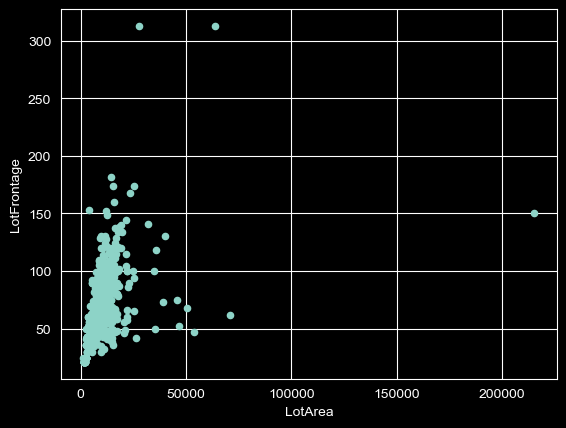

count    1201.000000
mean      -26.499856
std        22.045553
min      -313.945040
25%       -32.433760
50%       -24.852814
75%       -18.077641
max       146.717109
dtype: float64


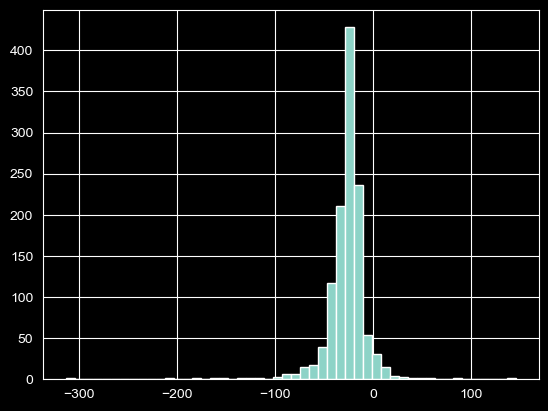

In [28]:
train_df.plot.scatter(x='LotArea', y='LotFrontage')
plt.show()

lot_front_area = train_df['LotFrontage'] - np.sqrt(train_df['LotArea'])
lot_front_area.hist(bins=50)
print(lot_front_area.describe())
mean_lot_frontage_shift = lot_front_area.mean()

For missing GarageYrBlt use YearBuilt. Fill electrical with the mode. Fill in lot frontage with the simple model.

In [29]:
train_df['GarageYrBlt'] = train_df['GarageYrBlt'].fillna(train_df['YearBuilt'])
train_df['LotFrontage'] = train_df['LotFrontage'].fillna(np.sqrt(train_df['LotArea']) + mean_lot_frontage_shift)

test_df['GarageYrBlt'] = test_df['GarageYrBlt'].fillna(test_df['YearBuilt'])
test_df['LotFrontage'] = test_df['LotFrontage'].fillna(np.sqrt(test_df['LotArea']) + mean_lot_frontage_shift)

In [30]:
print(train_df['MSSubClass'].value_counts())
print(test_df['MSSubClass'].value_counts())

MSSubClass
20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: count, dtype: int64
MSSubClass
20     543
60     276
50     143
120     95
30      70
70      68
160     65
80      60
90      57
190     31
85      28
75       7
180      7
45       6
40       2
150      1
Name: count, dtype: int64


There are some very rare categories in MSSubClass. To prevent overfitting, a rare label encoder will be used.

Check the number of missing data before the imputer.

In [31]:
print("Missing data in train_df:")
print(missing_data_table(train_df))
print("Missing data in test_df:")
print(missing_data_table(test_df))

Missing data in train_df:
              Total   Percent
MasVnrType       13  0.008904
MasVnrArea        8  0.005479
Electrical        1  0.000685
BsmtExposure      1  0.000685
BsmtFinType2      1  0.000685
Missing data in test_df:
              Total   Percent
MasVnrType       18  0.012337
MasVnrArea       15  0.010281
BsmtCond          4  0.002742
MSZoning          4  0.002742
PoolQC            3  0.002056
BsmtQual          3  0.002056
BsmtExposure      3  0.002056
BsmtFullBath      2  0.001371
BsmtHalfBath      2  0.001371
Functional        2  0.001371
GarageQual        2  0.001371
GarageCond        2  0.001371
Utilities         2  0.001371
GarageFinish      2  0.001371
BsmtFinSF1        1  0.000685
BsmtFinType1      1  0.000685
BsmtFinType2      1  0.000685
BsmtFinSF2        1  0.000685
BsmtUnfSF         1  0.000685
TotalBsmtSF       1  0.000685
KitchenQual       1  0.000685
Exterior1st       1  0.000685
Exterior2nd       1  0.000685
GarageCars        1  0.000685
MiscFeature       1

There is still some data missing. A pipeline is created to impute the missing data and perform rare label encoding.

In [32]:
# Define transformers for numerical and categorical columns
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('rare_label_encoder', RareLabelEncoder(tol=0.01))
])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ],remainder = 'passthrough')

# Create a pipeline with the preprocessor
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)]).set_output(transform="pandas")

X_imputed = pipeline.fit_transform(train_df.drop(columns=['SalePrice']))
y_imputed = np.log(train_df['SalePrice'])
test_imputed = pipeline.transform(test_df)

In [33]:
print("Missing data in X_imputed:")
print(missing_data_table(X_imputed))
print("Missing data in test_imputed:")
print(missing_data_table(test_imputed))

Missing data in X_imputed:
Empty DataFrame
Columns: [Total, Percent]
Index: []
Missing data in test_imputed:
Empty DataFrame
Columns: [Total, Percent]
Index: []


No missing data after the imputer.

Rerun the model to see the impact of imputing

In [34]:
for col in [x for x in X_imputed.columns if(x.startswith('cat__'))]:
    new_values_in_test = test_imputed[~test_imputed[col].isin(X_imputed[col])]
    if not new_values_in_test.empty:
        print(col)
        print(new_values_in_test[col])

There are no categories in the test set that do not exist in the train set.

In [35]:
test_imputed['cat__MSSubClass'].value_counts()

cat__MSSubClass
20      543
60      276
50      143
120      95
30       70
70       68
160      65
80       60
90       57
190      31
85       28
Rare     16
75        7
Name: count, dtype: int64

Mean: 0.14558963218735174
Std: 0.005756528475897049


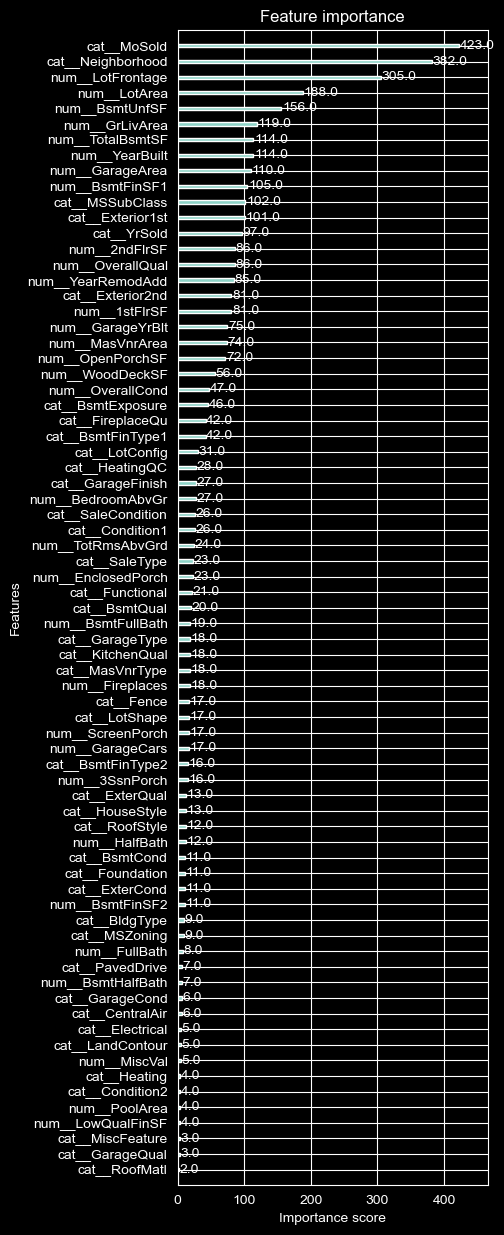

In [36]:
cat_cols_imputed = [x for x in X_imputed.columns if(x.startswith('cat__'))]
num_cols_imputed = [x for x in X_imputed.columns if(x.startswith('num__'))]

X_imputed[cat_cols_imputed] = X_imputed[cat_cols_imputed].astype(str).astype('category')
test_imputed[cat_cols_imputed] = test_imputed[cat_cols_imputed].astype(str).astype('category')

predictions = run_xgb(X_imputed,
                      y_imputed,
                      test_imputed,
                      default_xgb_params)

create_submission(predictions)

Imputing the columns caused the rmse to decrease from 0.148 to 0.146. Xgboost is able to handle missing and categorical and missing values, so the manual encoding did not improve the model significantly.

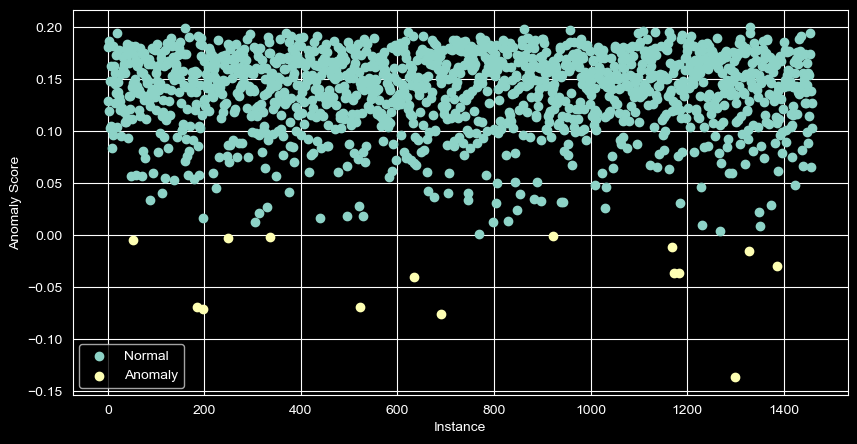

In [37]:
# Identify and remove outliers using Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=RANDOM_STATE)
iso_forest.fit(X_imputed[num_cols_imputed])

data = X_imputed.loc[X_imputed[num_cols_imputed].index].copy()
data['anomaly_score'] = iso_forest.decision_function(X_imputed[num_cols_imputed])
data['anomaly'] = iso_forest.predict(X_imputed[num_cols_imputed])

# Visualization of the results
plt.figure(figsize=(10, 5))

# Plot normal instances
normal = data[data['anomaly'] == 1]
plt.scatter(normal.index, normal['anomaly_score'], label='Normal')

# Plot anomalies
anomalies = data[data['anomaly'] == -1]
plt.scatter(anomalies.index, anomalies['anomaly_score'], label='Anomaly')
plt.xlabel("Instance")
plt.ylabel("Anomaly Score")
plt.legend()
plt.show()

normal_mask = data['anomaly'] == 1

X_masked = X_imputed[normal_mask]
y_masked = y_imputed[normal_mask]

Mean: 0.136509814817876
Std: 0.01131885183744228


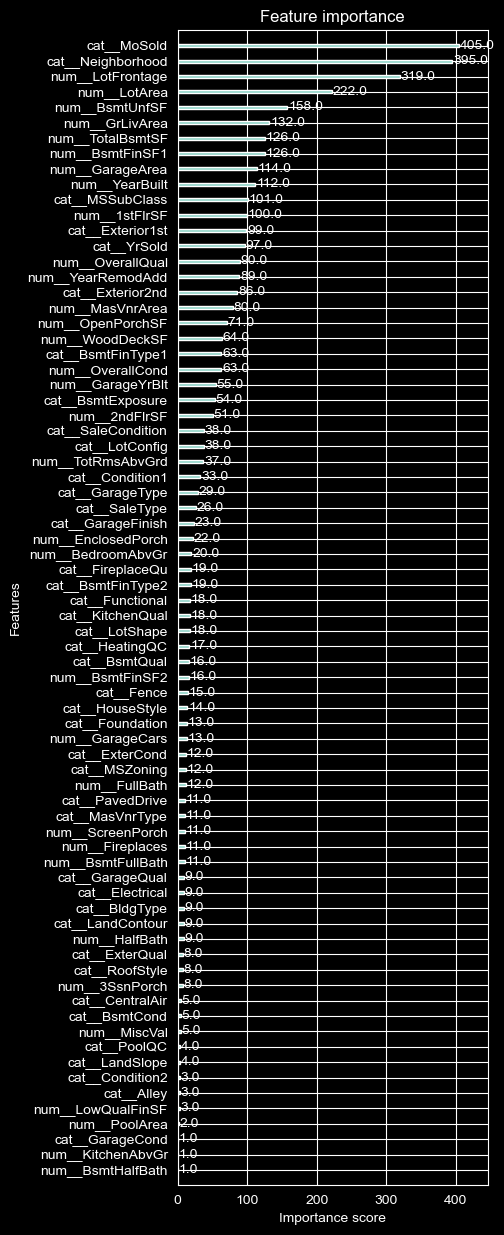

In [38]:
X_masked[cat_cols_imputed] = X_masked[cat_cols_imputed].astype(str).astype('category')

predictions = run_xgb(X_masked,
                      y_masked,
                      test_imputed,
                      default_xgb_params)
create_submission(predictions)

Removing outliers improved the rsme to 0.137

Create some new features.

In [39]:
X_masked['num__TotalBath'] = X_masked['num__BsmtFullBath'] + 0.5*X_masked['num__BsmtHalfBath'] + X_masked['num__FullBath'] + 0.5*X_masked['num__HalfBath']

test_imputed['num__TotalBath'] = test_imputed['num__BsmtFullBath'] + 0.5*test_imputed['num__BsmtHalfBath'] + test_imputed['num__FullBath'] + 0.5*test_imputed['num__HalfBath']

cat_cols_imputed = [x for x in X_imputed.columns if(x.startswith('cat__'))]
X_masked[cat_cols_imputed] = X_masked[cat_cols_imputed].astype(str).astype('category')
test_imputed[cat_cols_imputed] = test_imputed[cat_cols_imputed].astype(str).astype('category')

Mean: 0.13855926300789587
Std: 0.009536065006942708


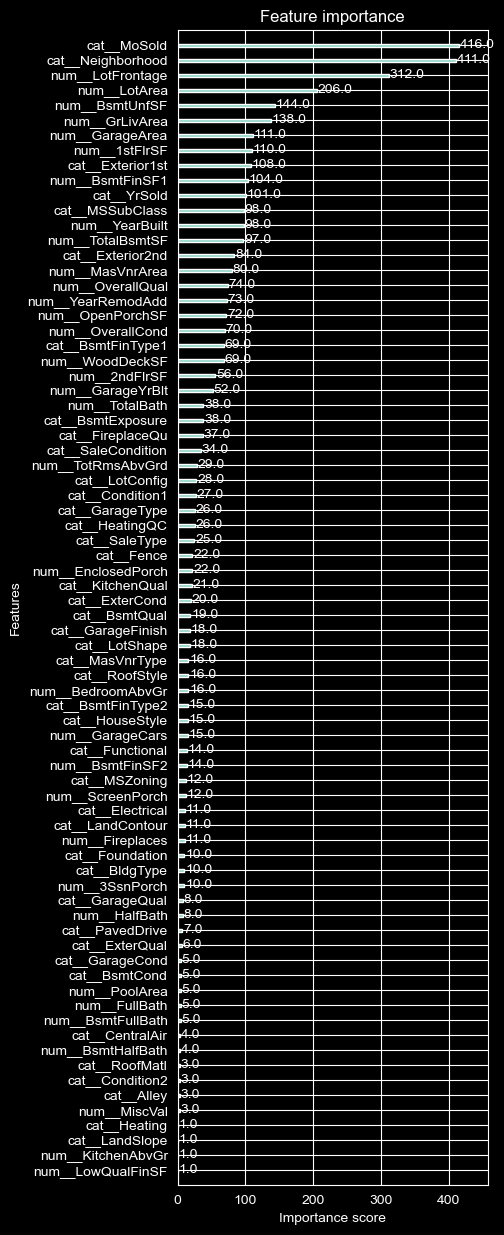

In [40]:
predictions = run_xgb(X_masked,
                      y_masked,
                      test_imputed,
                      default_xgb_params)
create_submission(predictions)

Adding this new feature did not improve the model quality

In [41]:
X = X_masked.copy()
y = y_masked.copy()

num__OverallQual     0.567622
cat__Neighborhood    0.528397
num__GrLivArea       0.459229
num__YearBuilt       0.381311
num__GarageArea      0.365763
                       ...   
cat__PoolQC          0.000000
num__PoolArea        0.000000
num__3SsnPorch       0.000000
cat__YrSold          0.000000
cat__LandSlope       0.000000
Name: MI Scores, Length: 80, dtype: float64


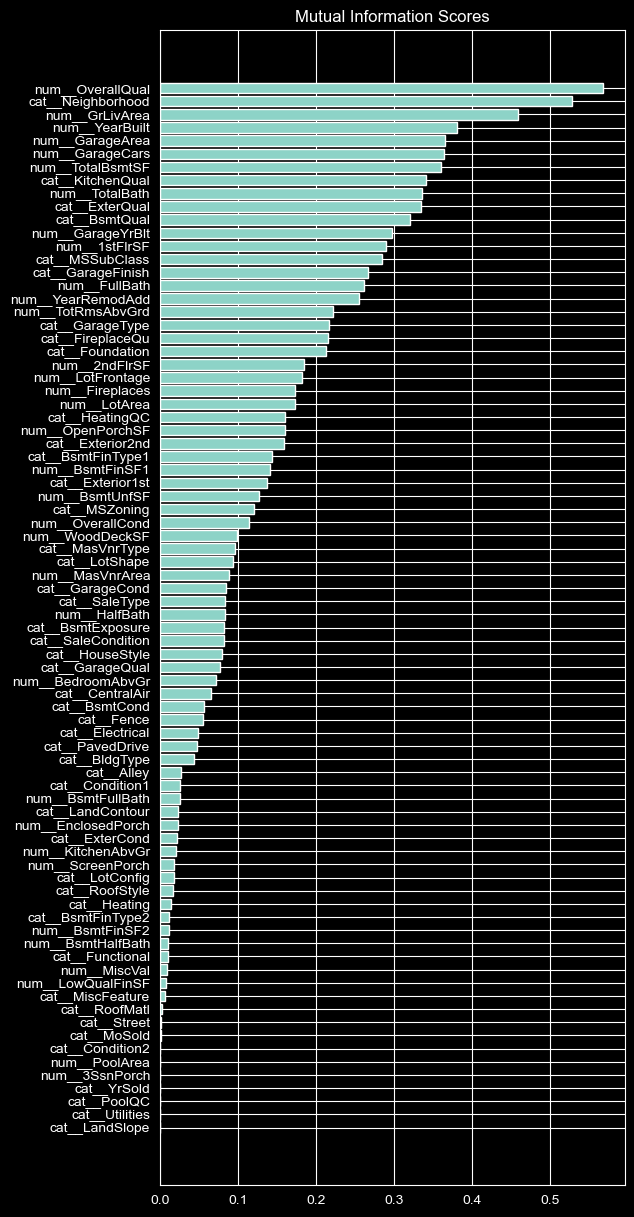

In [42]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    fig, axs = plt.subplots(1, 1, figsize=(6,15))
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    axs.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

mi_scores = make_mi_scores(X.copy(), y)
print(mi_scores)
plot_mi_scores(mi_scores)

There are certain features that do not provide information. Those features will be removed to prevent overfitting.

Mean: 0.13956667386817417
Std: 0.01200237317309372


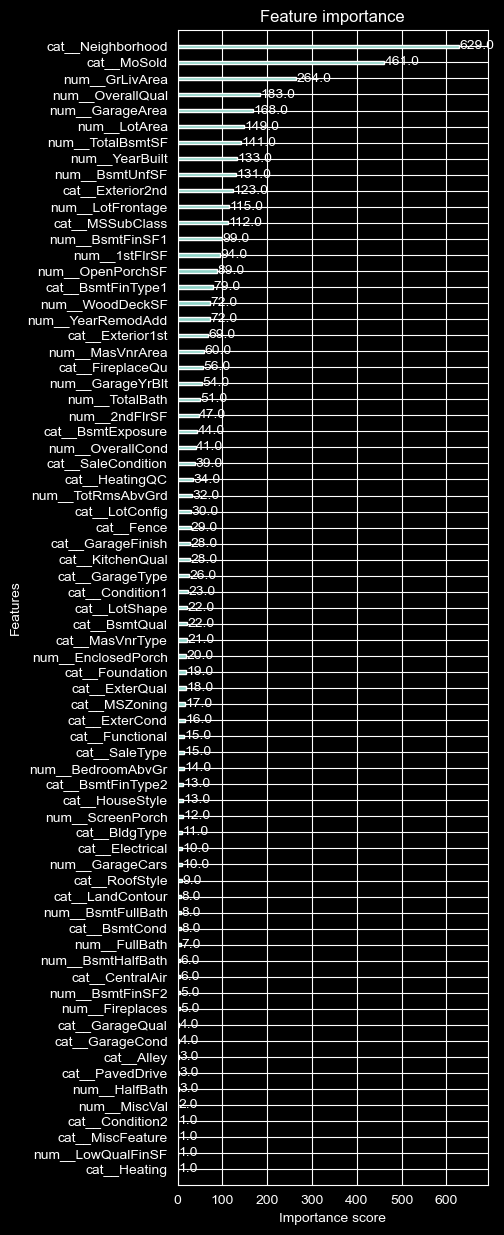

In [43]:
keep_features = mi_scores[mi_scores > 0].index.tolist()
X = X_masked.copy()
X_keep_features = X[keep_features]
test_keep_features = test_imputed[keep_features].copy()

cat_cols_keep_features = [x for x in X_keep_features.columns if(x.startswith('cat__'))]
num_cols_keep_features = [x for x in X_keep_features.columns if(x.startswith('num__'))]

X_keep_features[cat_cols_keep_features] = X_keep_features[cat_cols_keep_features].astype(str).astype('category')
test_keep_features[cat_cols_keep_features] = test_keep_features[cat_cols_keep_features].astype(str).astype('category')

predictions = run_xgb(X_keep_features,
                      y_masked,
                      test_keep_features,
                      default_xgb_params)
create_submission(predictions)

Removing some features increased the RMSE by a small amount.

In [44]:
def objective(trial):
    params = dict(
        objective='reg:squarederror',
        max_depth=trial.suggest_int("max_depth", 2, 10),
        learning_rate=trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        n_estimators=trial.suggest_int("n_estimators", 50, 1000),
        min_child_weight=trial.suggest_int("min_child_weight", 1, 10),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.2, 1.0),
        subsample=trial.suggest_float("subsample", 0.2, 1.0),
        reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 1e2, log=True),
        reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 1e2, log=True),
        seed=RANDOM_STATE,
        enable_categorical=True,
        early_stopping_rounds=20,
        pruning_callback = optuna.integration.XGBoostPruningCallback(trial, observation_key='validation_0-rmse')
    )

    cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    rsme = []
    for train_idx, valid_idx in cv.split(X, y):
        model = xgb.XGBRegressor(**params)
        model.fit(
            X_optuna.iloc[train_idx], y_optuna.iloc[train_idx],
            eval_set=[(X_optuna.iloc[valid_idx], y.iloc[valid_idx])],
            verbose=False
        )
        preds = model.predict(X_optuna.iloc[valid_idx])
        rsme.append(root_mean_squared_error(y_optuna.iloc[valid_idx], preds))
    return float(np.mean(rsme))

In [45]:
X_optuna = X_keep_features.copy()
X_optuna[cat_cols_keep_features] = X_keep_features[cat_cols_keep_features].astype(str).astype('category')
y_optuna = y_masked
test_optuna = test_keep_features.copy()
test_optuna[cat_cols_keep_features] = test_imputed[cat_cols_keep_features].astype(str).astype('category')

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)
optuna_params = study.best_params
print(optuna_params)

[I 2025-12-25 10:53:21,500] A new study created in memory with name: no-name-02743e92-71ed-4e21-91ed-0189c3ef703d
[I 2025-12-25 10:53:22,186] Trial 0 finished with value: 0.3814821646093506 and parameters: {'max_depth': 3, 'learning_rate': 0.0004378269026293082, 'n_estimators': 113, 'min_child_weight': 3, 'colsample_bytree': 0.27733723740651905, 'subsample': 0.8623275036830866, 'reg_alpha': 0.008791648130077124, 'reg_lambda': 1.4064258438235864}. Best is trial 0 with value: 0.3814821646093506.
[I 2025-12-25 10:53:24,973] Trial 1 finished with value: 0.35684752197459824 and parameters: {'max_depth': 4, 'learning_rate': 0.000299724202398115, 'n_estimators': 457, 'min_child_weight': 8, 'colsample_bytree': 0.9823352994674919, 'subsample': 0.6653421919409271, 'reg_alpha': 0.5002032731609047, 'reg_lambda': 0.00038334020814493805}. Best is trial 1 with value: 0.35684752197459824.
[I 2025-12-25 10:53:27,364] Trial 2 finished with value: 0.2581395360023636 and parameters: {'max_depth': 10, 'lea

{'max_depth': 7, 'learning_rate': 0.012849280553178995, 'n_estimators': 995, 'min_child_weight': 2, 'colsample_bytree': 0.3388952746796793, 'subsample': 0.2798637761523221, 'reg_alpha': 0.0013231373052777645, 'reg_lambda': 0.0003264383841687806}


Mean: 0.11177189008839897
Std: 0.00740599385061536


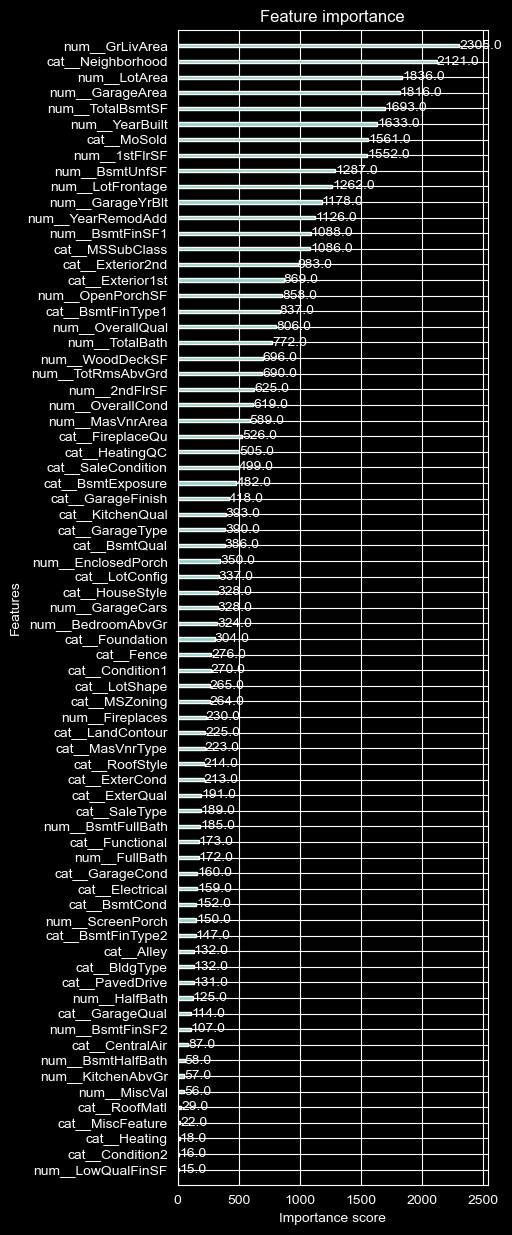

In [46]:
optuna_params.update({
    "objective": "reg:squarederror",
    "seed": RANDOM_STATE,
    'enable_categorical': True,
    'eval_metric': 'rmse'
    })

predictions = run_xgb(X_optuna,
                      y_optuna,
                      test_optuna,
                      optuna_params)

create_submission(predictions)

The public score is 0.12517.

Step taken:
* Imputing numerical values with the median and categorical values with the mode
* Using rare label encoder to merge rare values
* Isolation Forest to remove outliers
* Creating new features
* Using mutual information to remove unimportant features
* Using Optuna to tune hyperparameters

Lessons learned:
* Baseline XGBoost is pretty good at regression analysis. All of the steps taken to improve the score, only improved the score by about 20%
* Optuna lead to the largest improvement of the score (improved by ~18%).
* Removing outliers lead to second largest improvement of the score (improved by ~6%).
* Imputing, creating new feautres and removing unimportant did not have a significant impact on the score.

Potential next steps:
* Create a better way to impute the lot frontage and other numerical columns
* Create new features. For example, the area of the backyard (area lot - area of house).
* Try different machine learning models